# Analysis of Sensor and Lab samples Intermediate Datasets

In [193]:
import os
import sys

sys.path.append("..")

import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import scipy.stats as stats

from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance

from utils.functions.normalize_string import normalize_string

In [194]:
data_folder = os.path.join("..", "data")
utils_folder = os.path.join("..", "utils")

clean_data_folder = os.path.join(data_folder, "Clean Data")

# Load Data

In [195]:
eb0_features_lab_df = pd.read_excel(
    os.path.join(clean_data_folder, "EB0_Features_Lab.xlsx")
)

eb0_targets_lab_df = pd.read_excel(
    os.path.join(clean_data_folder, "EB0_Targets_Lab.xlsx")
)

In [196]:
eb1_features_lab_df = pd.read_excel(
    os.path.join(clean_data_folder, "EB1_Features_Lab.xlsx")
)

eb1_targets_lab_df = pd.read_excel(
    os.path.join(clean_data_folder, "EB1_Targets_Lab.xlsx")
)

In [197]:
eb0_sensor_df = pd.read_excel(
    os.path.join(clean_data_folder, "EB0_Sensor.xlsx")
)

In [198]:
eb1_sensor_df = pd.read_excel(
    os.path.join(clean_data_folder, "EB1_Sensor.xlsx")
)

In [199]:
# TODO change json names in 1-intermediate.ipynb and in the mappings folder in utils
# import feature mappings
with open(
    os.path.join(utils_folder, "mappings", "eb0_features_mapping_clean.json")
) as f:
    eb0_features_mapping = json.load(f)

with open(
    os.path.join(utils_folder, "mappings", "eb1_features_mapping_clean.json")
) as f:
    eb1_features_mapping = json.load(f)

In [200]:
eb1_sensor_df

,DateTime,CLOR LLIURE,COLOR,CONDUCTIVITAT,PH,TERBOLESA
0,2020-03-03 01:10:00,0.82440,2.12500,840.0,7.705272,0.032070
1,2020-03-03 01:20:00,0.87208,2.12500,840.0,7.707566,0.037284
2,2020-03-03 01:30:00,0.95753,2.12500,840.0,7.704172,0.036565
3,2020-03-03 01:40:00,0.94611,2.12500,840.0,7.704019,0.036422
4,2020-03-03 01:50:00,0.95713,2.12500,840.0,7.704172,0.036559
...,...,...,...,...,...,...
100630,2022-06-12 04:40:00,1.05068,0.68750,1072.0,7.637160,0.035630
100631,2022-06-12 04:50:00,1.04049,0.68750,1072.0,7.635720,0.034290
100632,2022-06-18 16:30:00,1.13124,0.69531,1088.0,7.657310,0.036540
100633,2022-06-19 01:50:00,1.07849,0.69531,1088.0,7.650680,0.033750


# Lab vs Sensor Data

## EB0

In [201]:
eb0_features_lab_df.columns = [
    normalize_string(c) for c in eb0_features_lab_df.columns
]

eb0_features_mapping = {
    normalize_string(k): v for k, v in eb0_features_mapping.items()
}

### Histograms

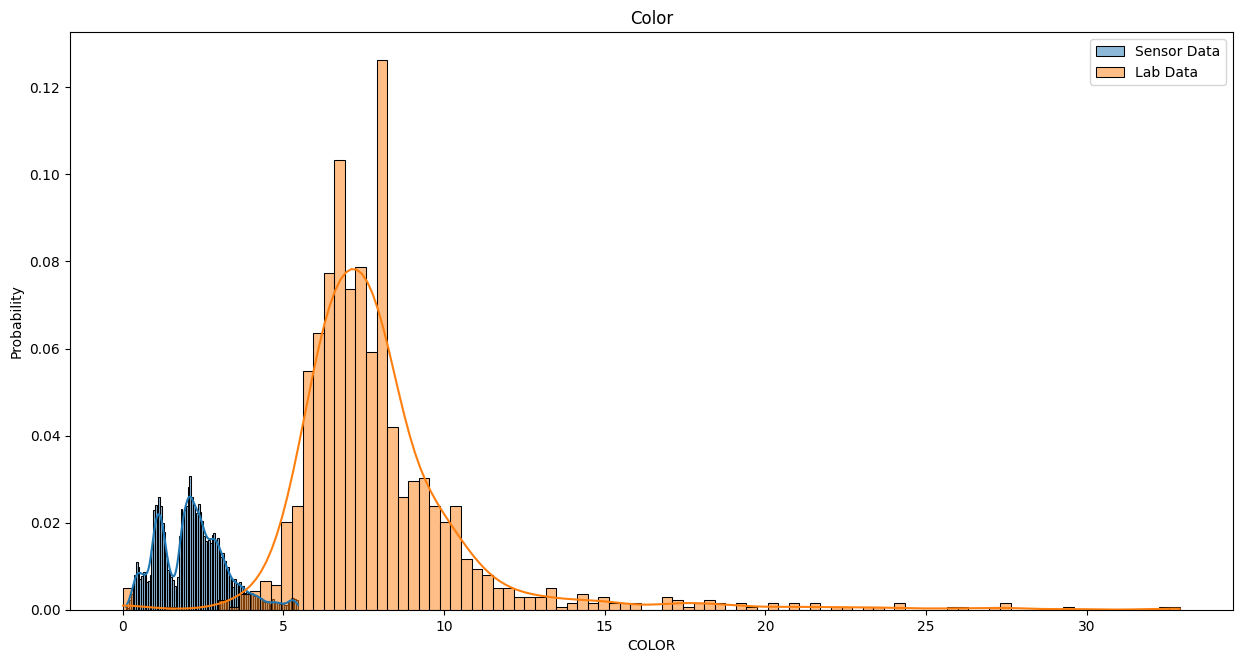

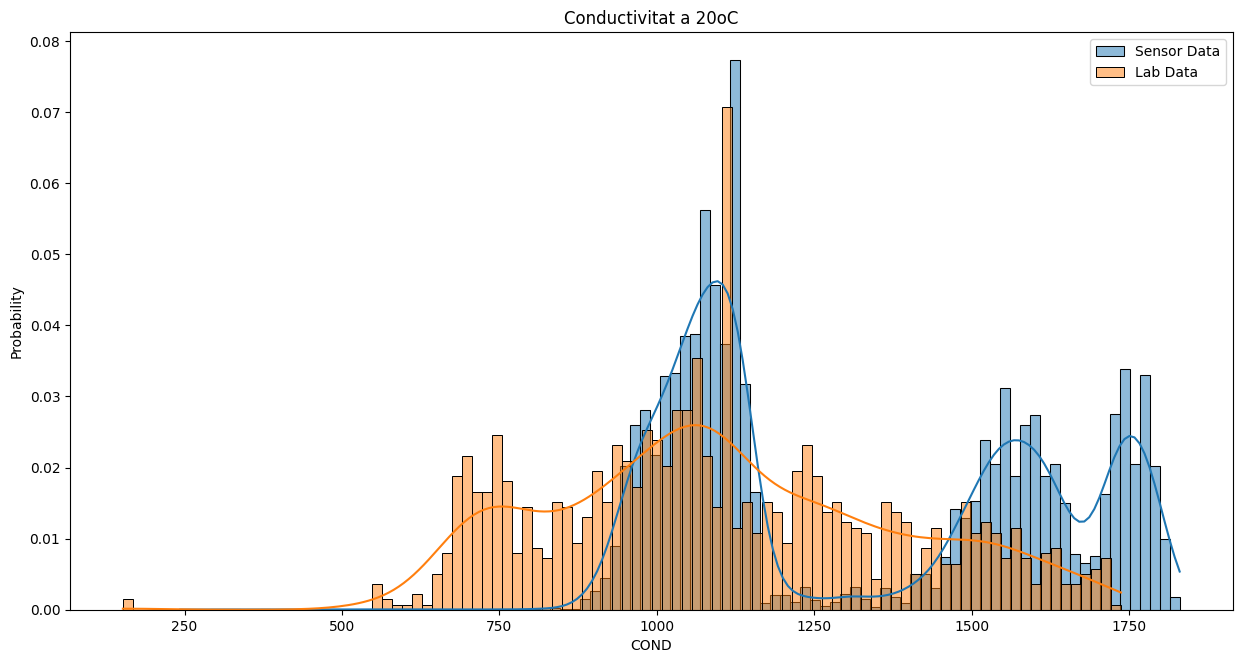

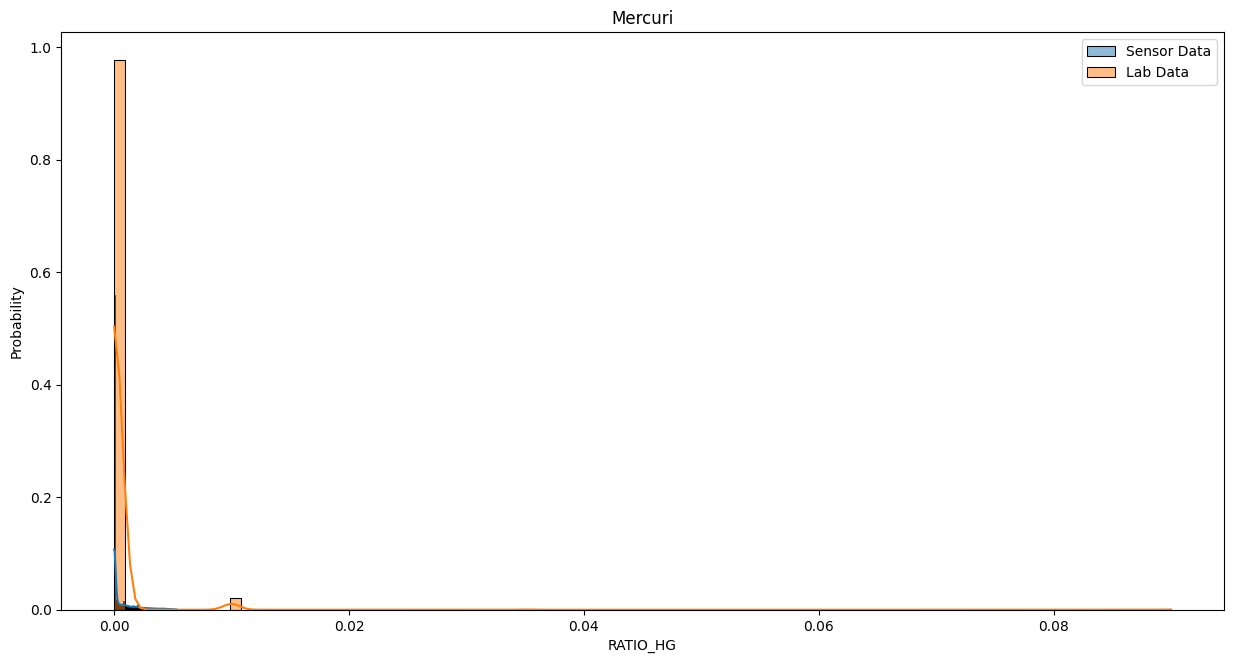

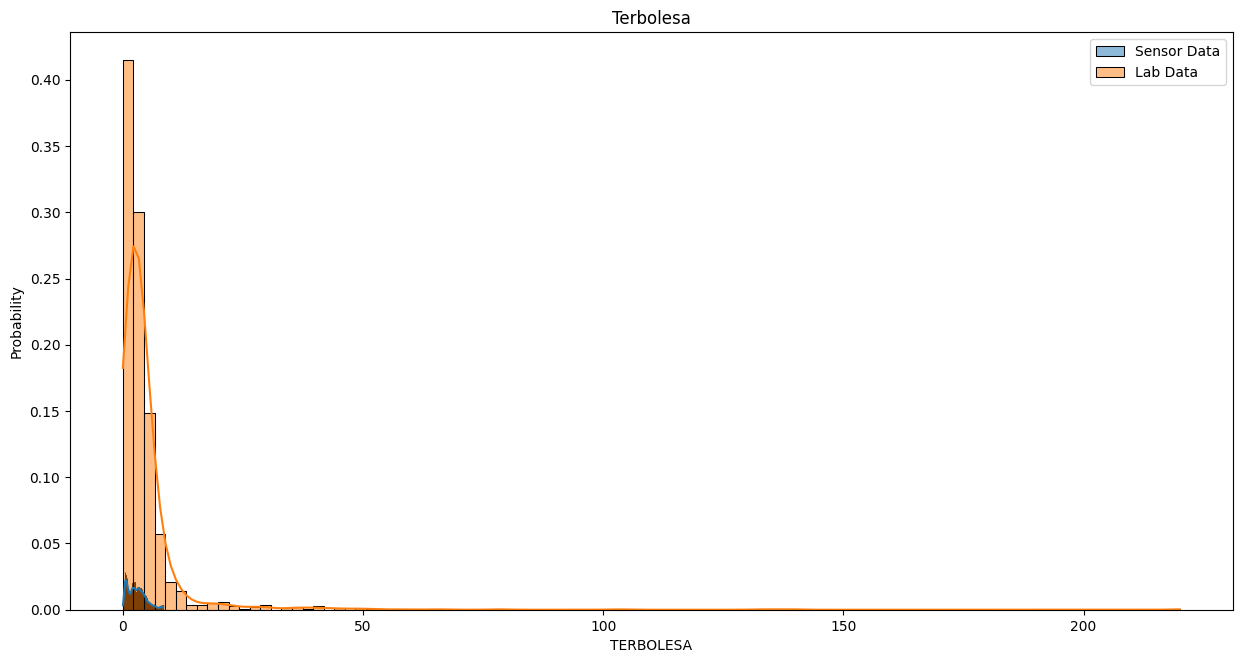

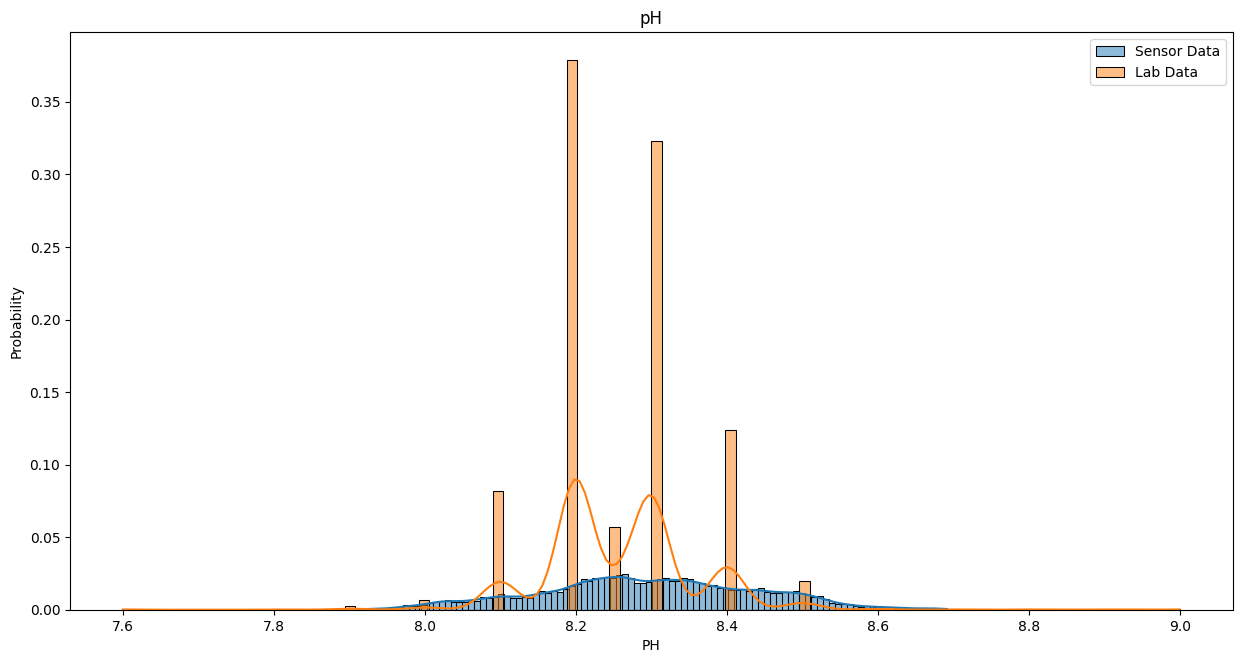

In [202]:
for lab_key, sensor_key in eb0_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb0_features_lab_df[lab_key]
    sensor_df = eb0_sensor_df[sensor_key]

    # remove 0 values from sensor data
    # sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        plt.figure(figsize=(15, 7.5))

        sns.histplot(
            data=sensor_df,
            kde=True,
            bins=100,
            alpha=0.5,
            stat="probability",
            label="Sensor Data",
        )

        sns.histplot(
            data=lab_df,
            kde=True,
            bins=100,
            stat="probability",
            label="Lab Data",
        )

        plt.title(lab_key)
        plt.legend()
        plt.show()

        # The y-axis of a histplot with stat="probability" corresponds
        # to the probability that a value belongs to a certain bar.
        # The sum of the bar heights must be 1.

### Boxplots

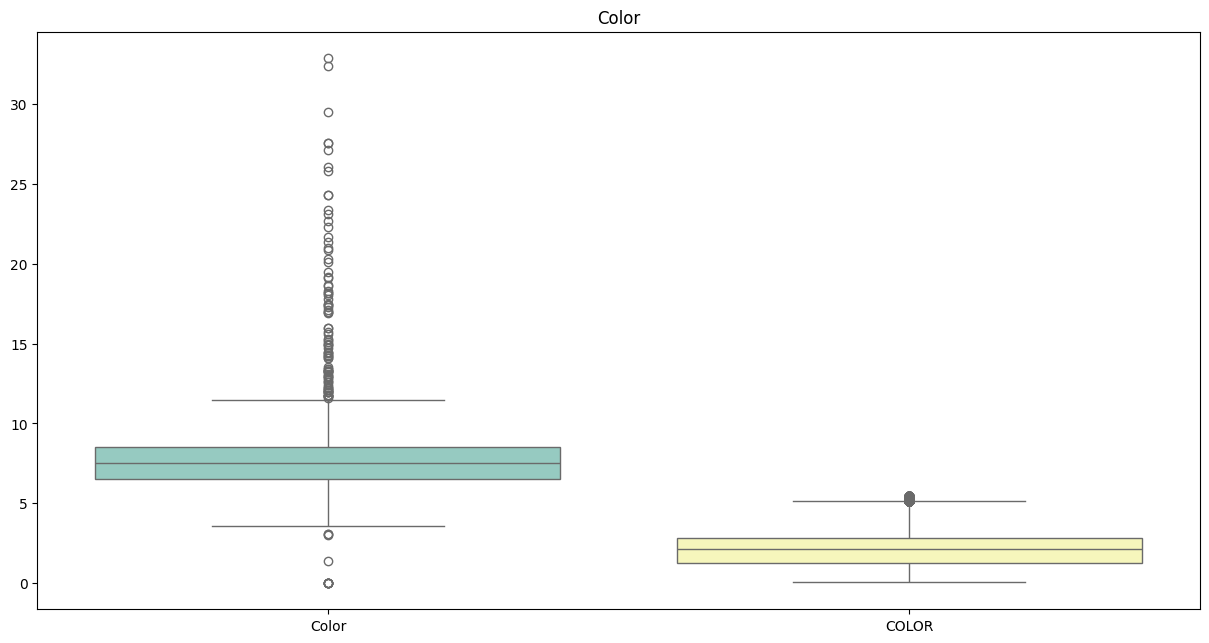

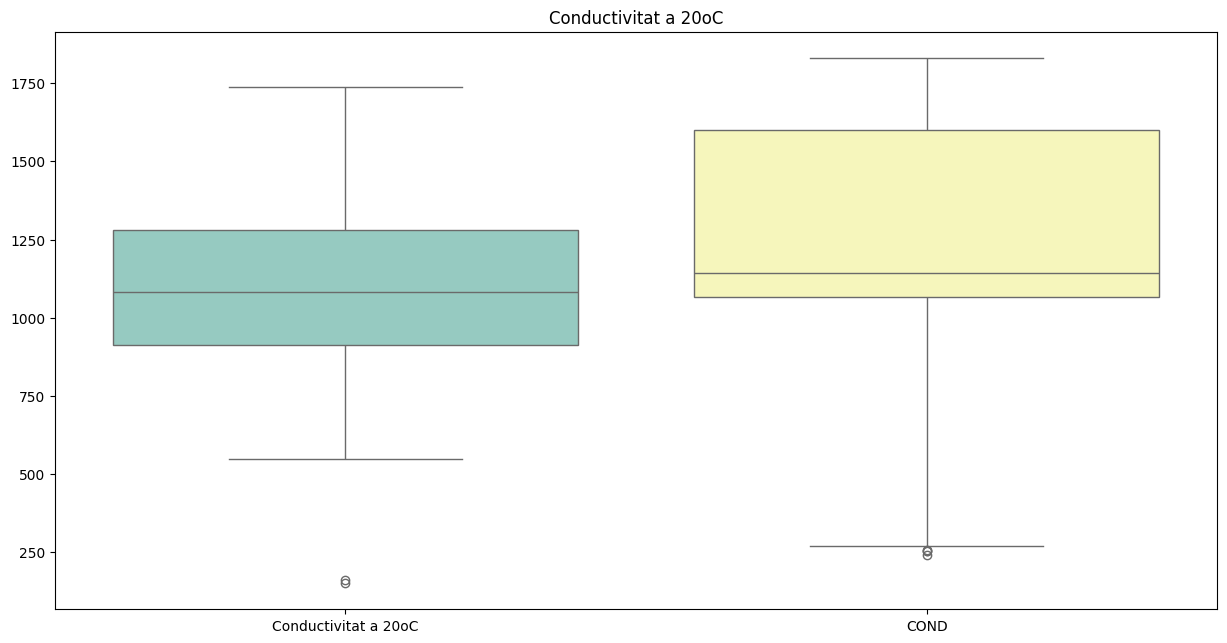

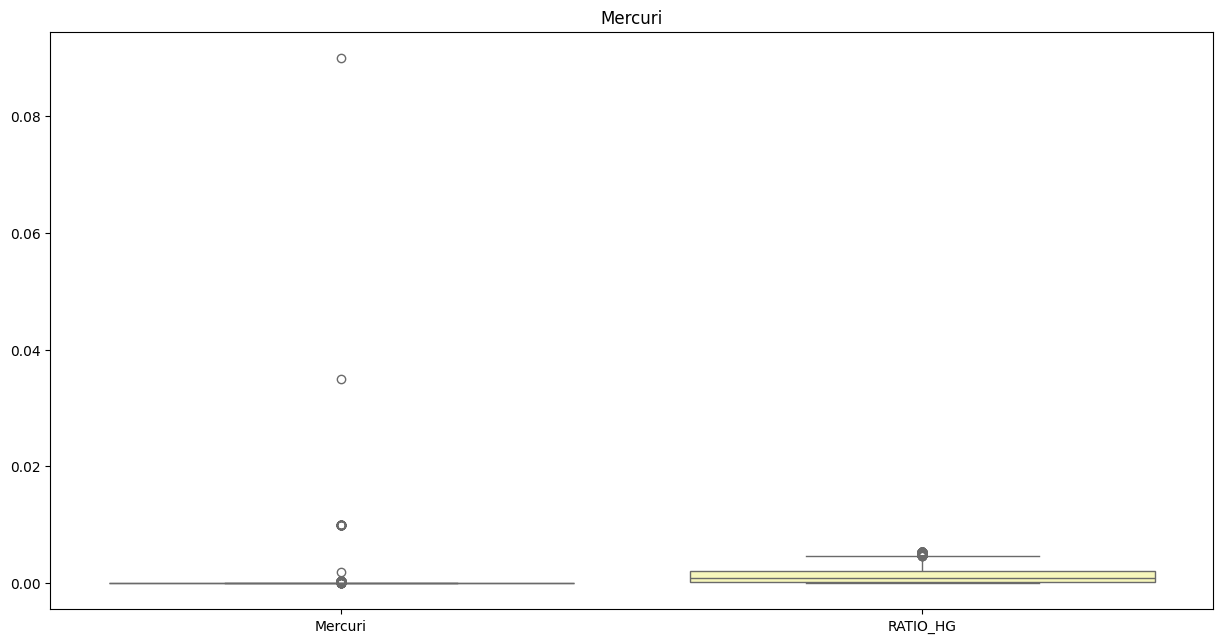

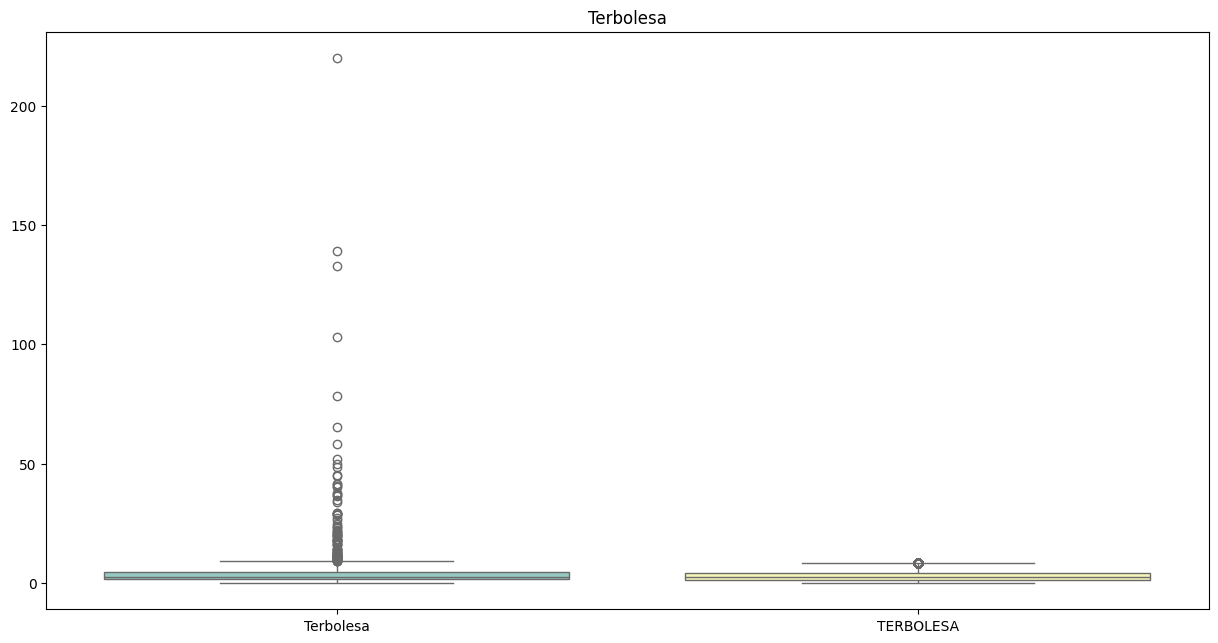

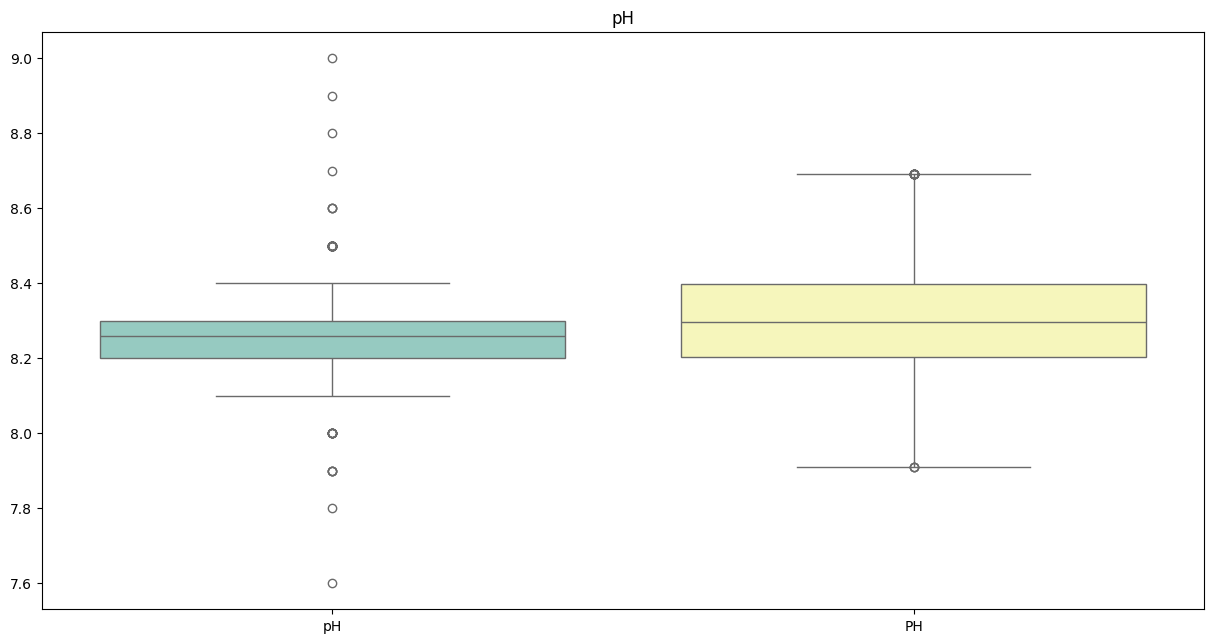

In [203]:
for lab_key, sensor_key in eb0_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb0_features_lab_df[lab_key]
    sensor_df = eb0_sensor_df[sensor_key]

    # remove 0 values from sensor data
    sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        plt.figure(figsize=(15, 7.5))

        sns.boxplot(data=[lab_df, sensor_df], palette="Set3")

        plt.title(lab_key)
        plt.show()

### Time series

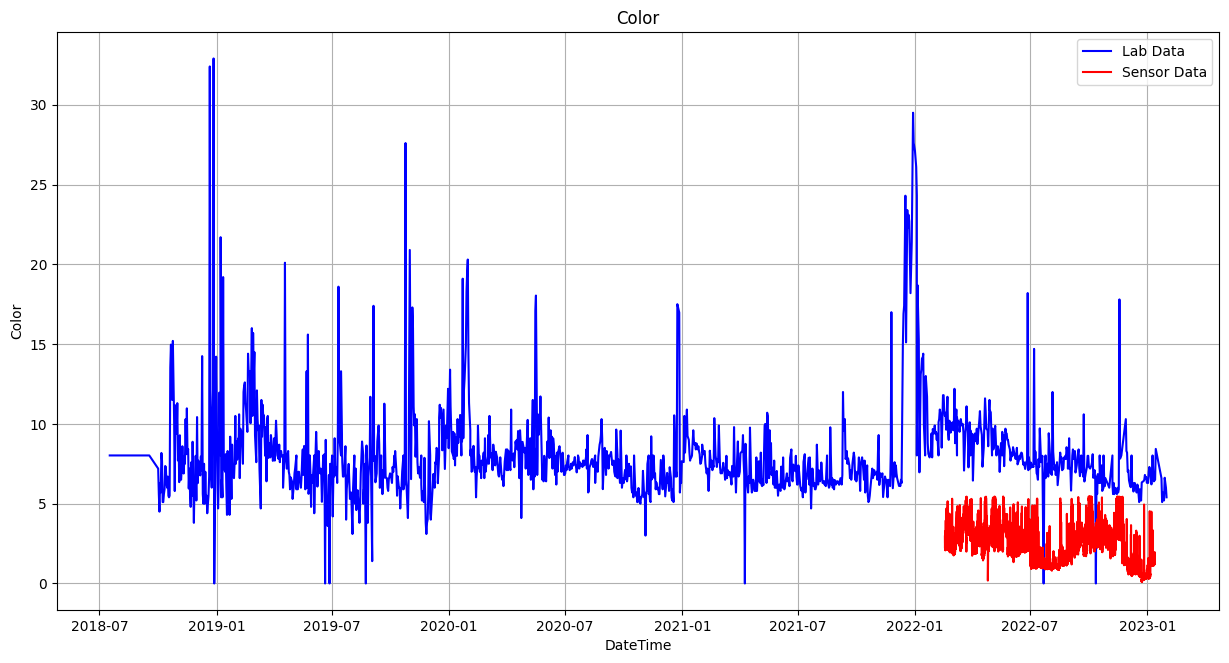

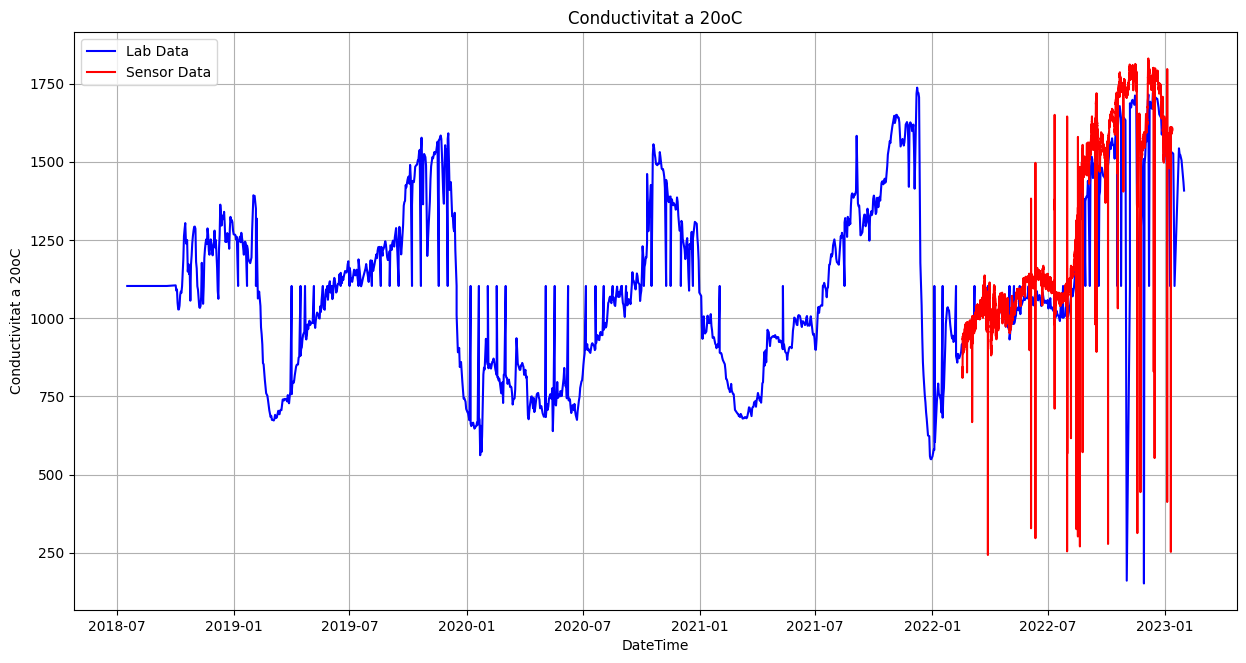

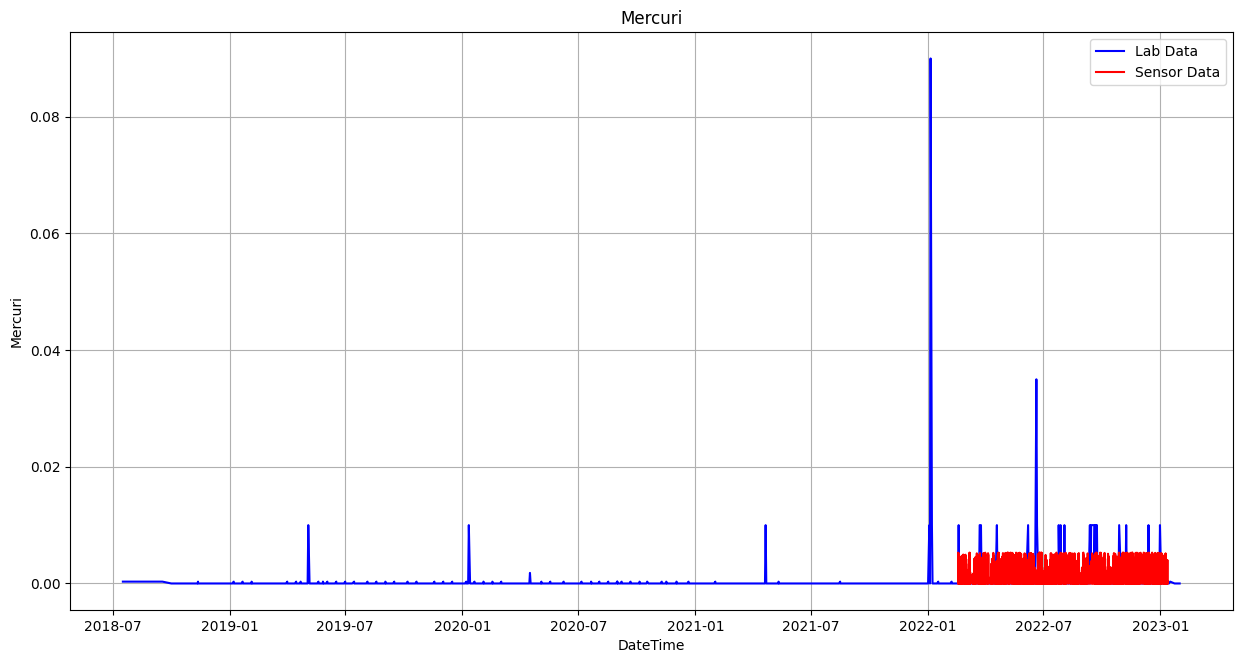

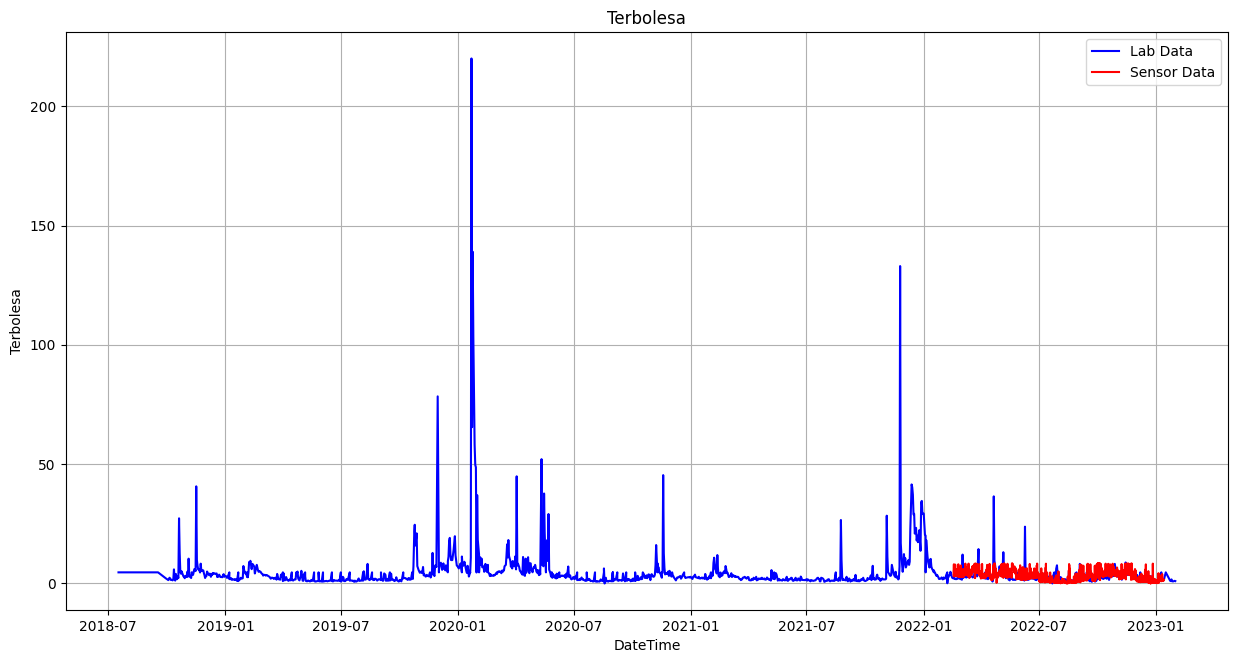

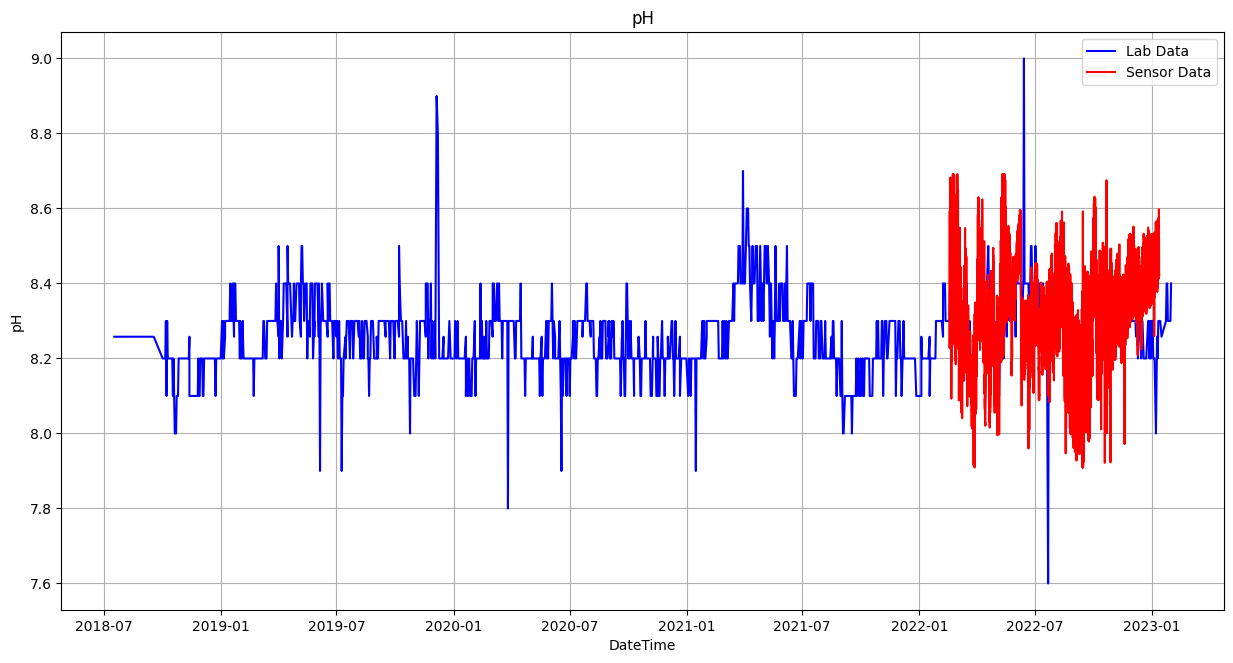

In [204]:
for lab_key, sensor_key in eb0_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb0_features_lab_df[["DateTime", lab_key]]
    sensor_df = eb0_sensor_df[["DateTime", sensor_key]]

    # remove 0 values from sensor data
    sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        plt.figure(figsize=(15, 7.5))

        sns.lineplot(
            x="DateTime",
            y=lab_key,
            data=lab_df,
            color="blue",
            label="Lab Data",
        )

        sns.lineplot(
            x="DateTime",
            y=sensor_key,
            data=sensor_df,
            color="red",
            label="Sensor Data",
        )

        plt.title(lab_key)
        plt.legend()
        plt.grid(True)
        plt.show()

### Retrieve Common Time Range data + Hypothesis Tests

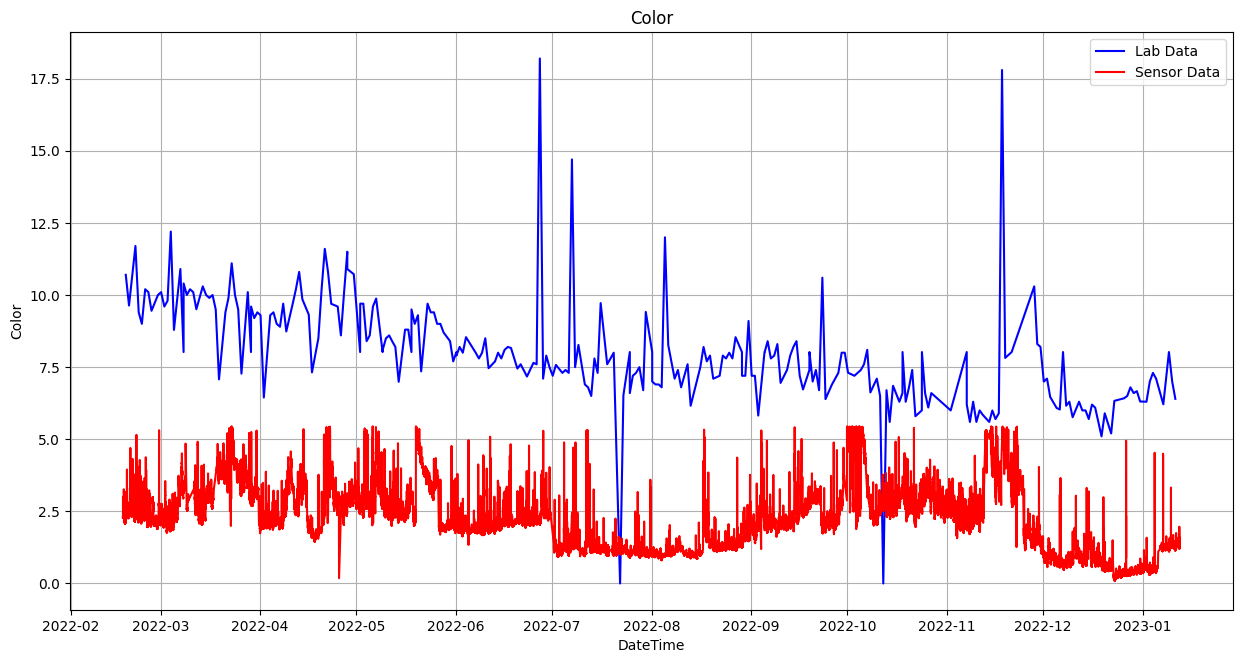

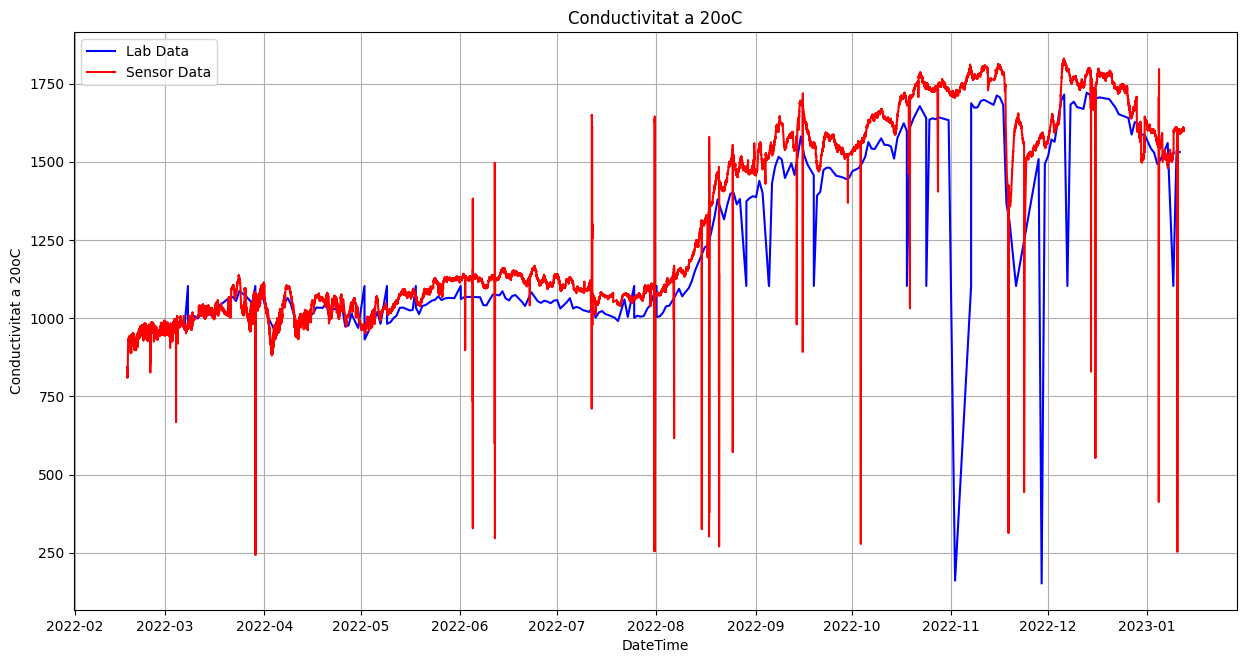

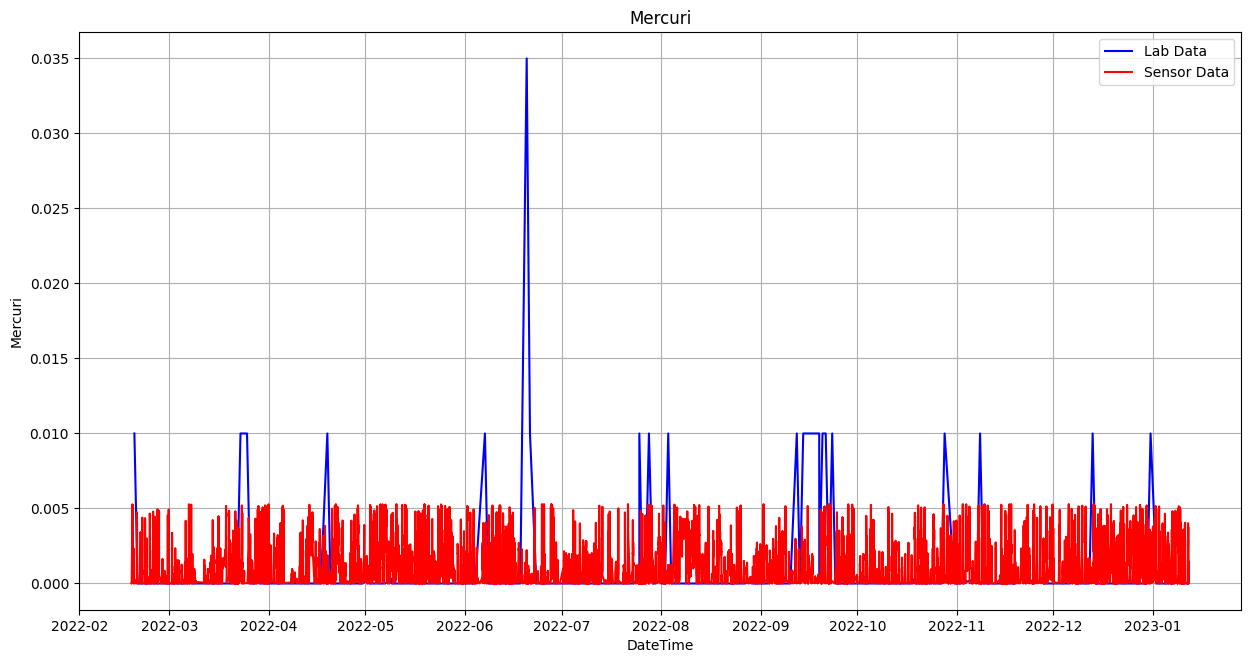

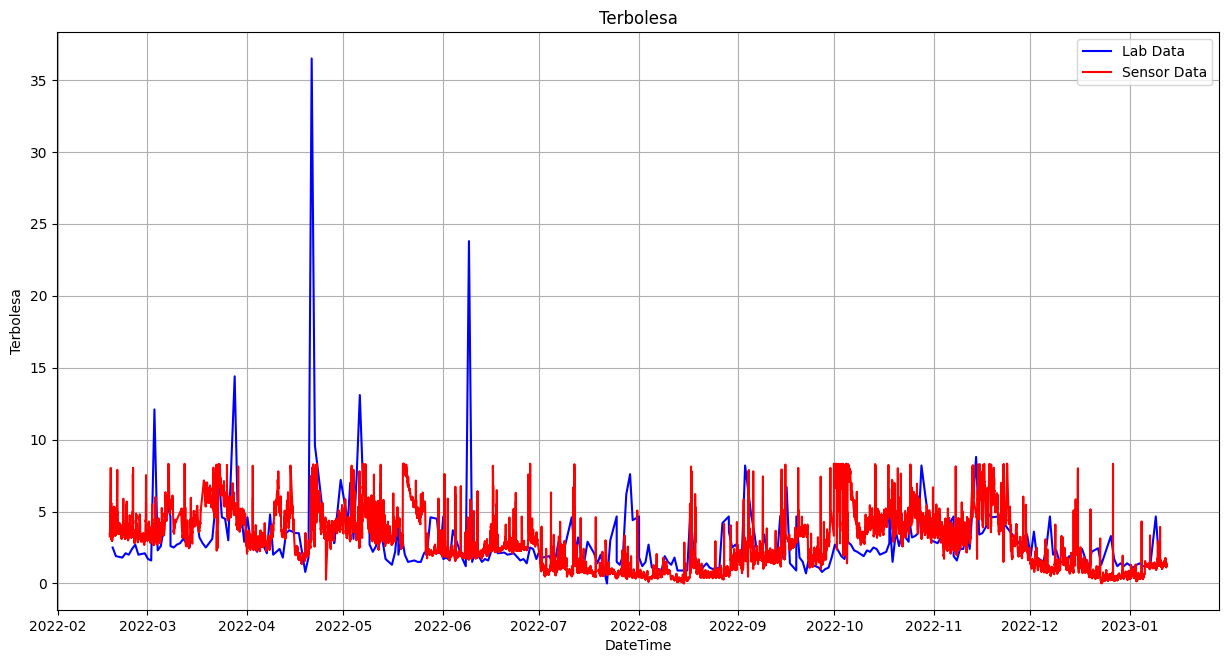

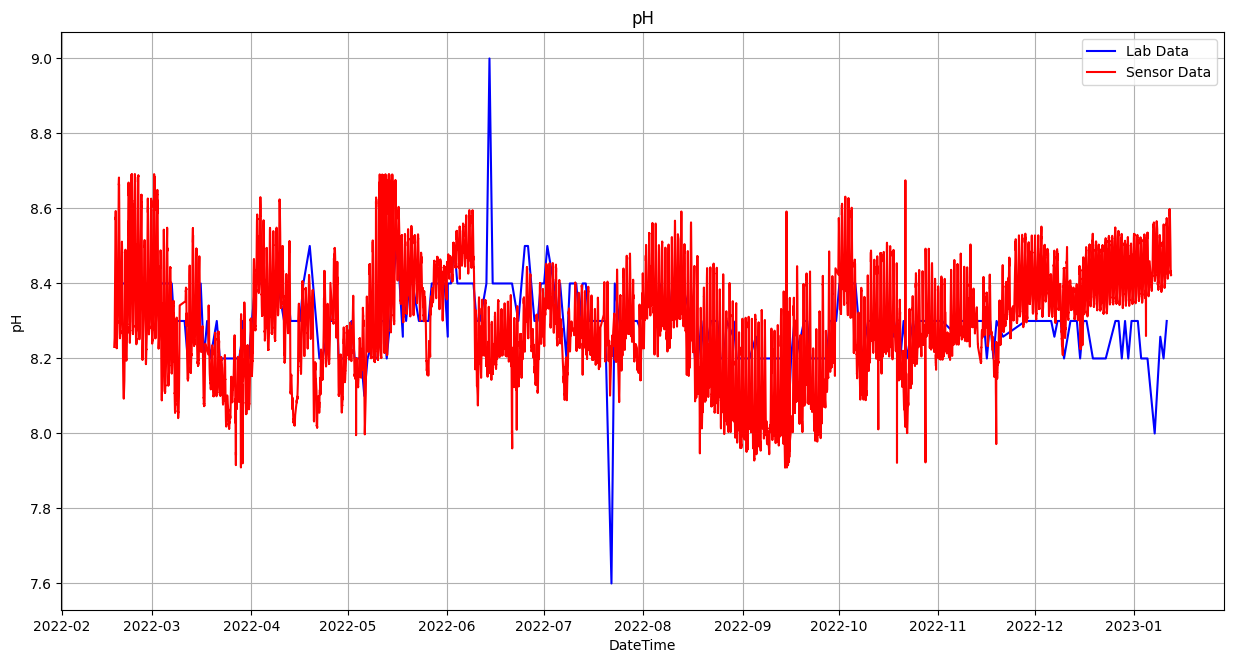

In [205]:
ks_hypothesis_tests = {}
t_hypothesis_tests = {}
u_hypothesis_tests = {}

# get common time range samples for lab and sensor data
for lab_key, sensor_key in eb0_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb0_features_lab_df[["DateTime", lab_key]]
    sensor_df = eb0_sensor_df[["DateTime", sensor_key]]

    # remove 0 values from sensor data
    sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        lab_time_range_df = lab_df[
            (lab_df["DateTime"] >= sensor_df["DateTime"].min())
            & (lab_df["DateTime"] <= sensor_df["DateTime"].max())
        ]

        sensor_time_range_df = sensor_df[
            (sensor_df["DateTime"] >= lab_df["DateTime"].min())
            & (sensor_df["DateTime"] <= lab_df["DateTime"].max())
        ]

        plt.figure(figsize=(15, 7.5))

        sns.lineplot(
            x="DateTime",
            y=lab_key,
            data=lab_time_range_df,
            color="blue",
            label="Lab Data",
        )

        sns.lineplot(
            x="DateTime",
            y=sensor_key,
            data=sensor_time_range_df,
            color="red",
            label="Sensor Data",
        )

        # two sample KS test
        ks_result, ks_p_value = stats.ks_2samp(
            lab_df[lab_key], sensor_df[sensor_key]
        )
        t_result, t_p_value = stats.ttest_ind(
            lab_df[lab_key].dropna(), sensor_df[sensor_key].dropna()
        )
        u_result, u_p_value = stats.mannwhitneyu(
            lab_df[lab_key].dropna(), sensor_df[sensor_key].dropna()
        )

        ks_hypothesis_tests[lab_key] = {
            "ks_test": ks_result,
            "p_value": ks_p_value,
        }

        t_hypothesis_tests[lab_key] = {"t_test": t_result, "p_value": t_p_value}

        u_hypothesis_tests[lab_key] = {"u_test": u_result, "p_value": u_p_value}

        plt.title(lab_key)
        plt.grid(True)
        plt.legend()
        plt.show()

In [206]:
pd.DataFrame(ks_hypothesis_tests).T

,ks_test,p_value
Color,0.954533,0.000000e+00
Conductivitat a 20oC,0.304919,4.774991e-113
Mercuri,NaN,NaN
Terbolesa,0.172605,5.273405e-36
pH,0.338565,5.368922e-140


In [207]:
pd.DataFrame(t_hypothesis_tests).T

,t_test,p_value
Color,193.808040,0.000000e+00
Conductivitat a 20oC,-27.337746,7.079776e-164
Mercuri,-26.088260,5.666437e-149
Terbolesa,29.562814,3.706747e-191
pH,-9.828577,8.707763e-23


In [208]:
pd.DataFrame(u_hypothesis_tests).T

,u_test,p_value
Color,122032813.5,0.000000e+00
Conductivitat a 20oC,37503155.5,3.454185e-137
Mercuri,3609818.0,0.000000e+00
Terbolesa,67528239.5,2.657418e-10
pH,49883570.5,2.036922e-33


### Distributions Divergence

In [209]:
kl_divs = {}
js_divs = {}
tv_dists = {}
w_dists = {}

for lab_key, sensor_key in eb0_features_mapping.items():
    # Compute the probability distribution of the feature in each DataFrame
    lab_df = eb0_features_lab_df[lab_key]
    sensor_df = eb0_sensor_df[sensor_key]

    lab_pdist = np.histogram(lab_df.dropna(), bins=100, density=True)[0]
    sensor_pdist = np.histogram(sensor_df.dropna(), bins=100, density=True)[0]

    # Add a small constant to avoid division by zero
    lab_pdist = lab_pdist + np.finfo(np.float64).eps
    sensor_pdist = sensor_pdist + np.finfo(np.float64).eps

    # Compute divergence metrics
    kl_div = stats.entropy(lab_pdist, sensor_pdist)
    js_div = jensenshannon(lab_pdist, sensor_pdist)
    tv_dist = np.sum(np.abs(lab_pdist - sensor_pdist)) / 2
    w_dist = wasserstein_distance(lab_pdist, sensor_pdist)

    kl_divs[lab_key] = kl_div
    js_divs[lab_key] = js_div
    tv_dists[lab_key] = tv_dist
    w_dists[lab_key] = w_dist


kl_divs = pd.Series(kl_divs)
js_divs = pd.Series(js_divs)
tv_dists = pd.Series(tv_dists)
w_dists = pd.Series(w_dists)

In [210]:
kl_divs

Color                   1.106828
Conductivitat a 20oC    1.416570
Mercuri                 0.563595
Terbolesa               3.982833
pH                      2.393907
dtype: float64

In [211]:
js_divs

Color                   0.513513
Conductivitat a 20oC    0.425976
Mercuri                 0.422507
Terbolesa               0.741672
pH                      0.716234
dtype: float64

In [212]:
tv_dists

Color                      8.018782
Conductivitat a 20oC       0.030173
Mercuri                 8895.368791
Terbolesa                  6.041287
pH                        84.591054
dtype: float64

In [213]:
w_dists

Color                     0.156133
Conductivitat a 20oC      0.000286
Mercuri                 177.907376
Terbolesa                 0.115544
pH                        1.648171
dtype: float64

## EB1

In [214]:
eb1_features_lab_df.columns = [
    normalize_string(c) for c in eb1_features_lab_df.columns
]

eb1_features_mapping = {
    normalize_string(k): v for k, v in eb1_features_mapping.items()
}

### Histograms

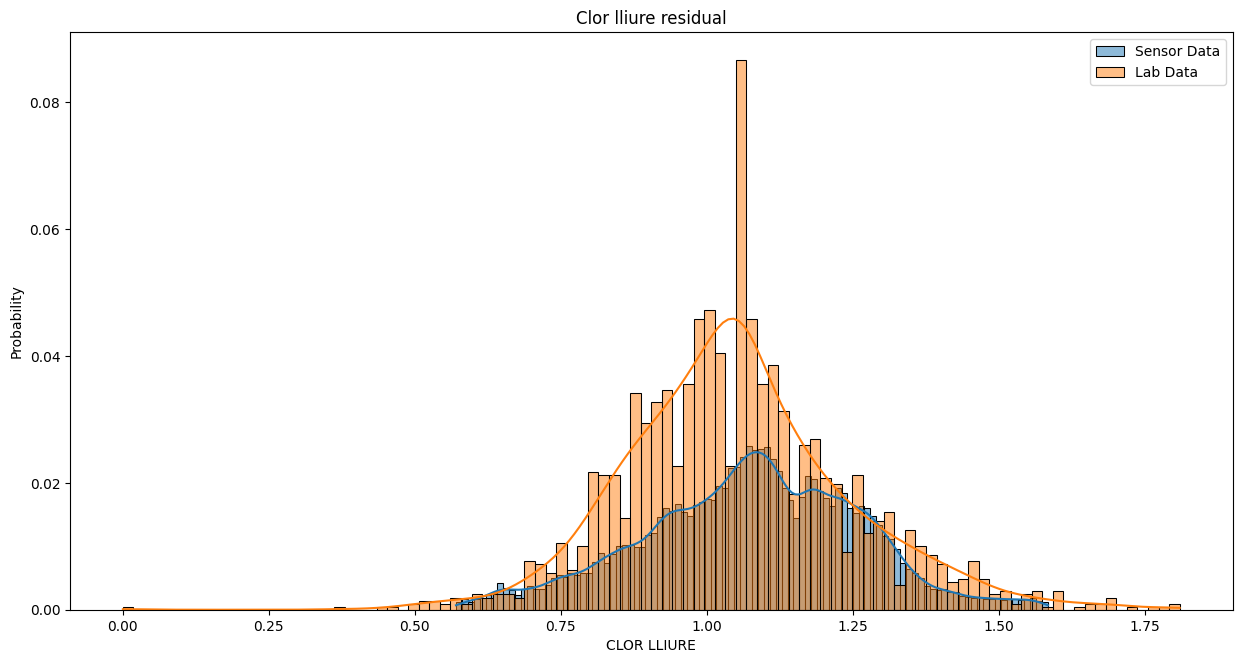

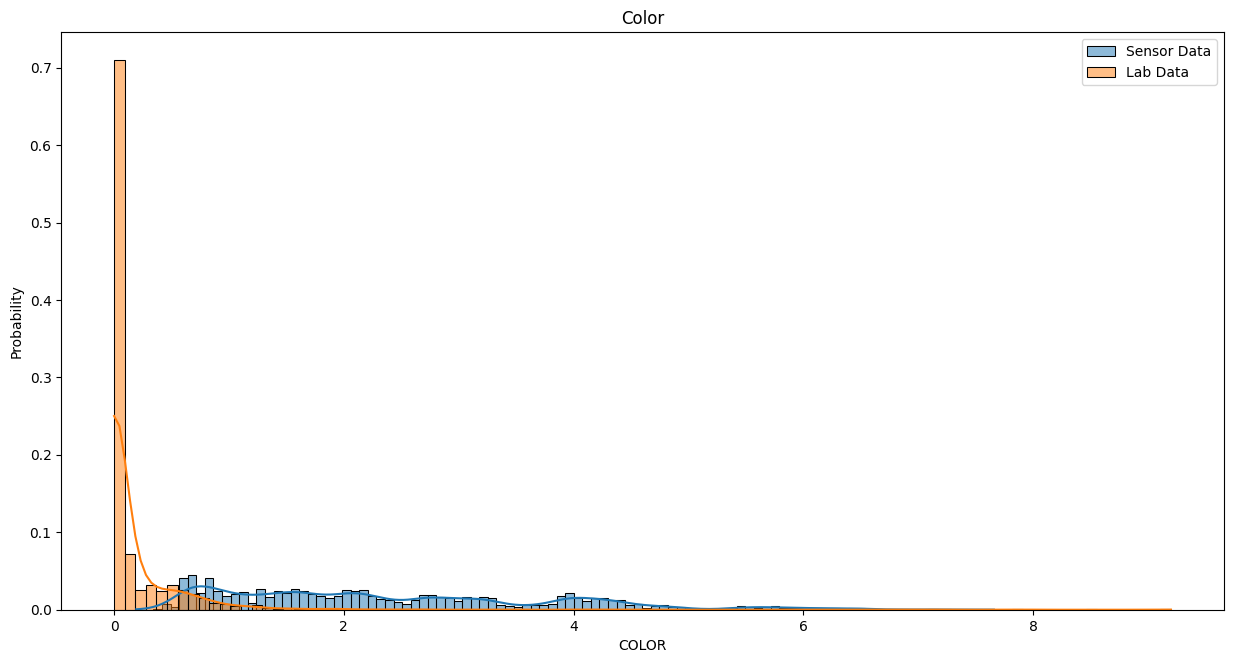

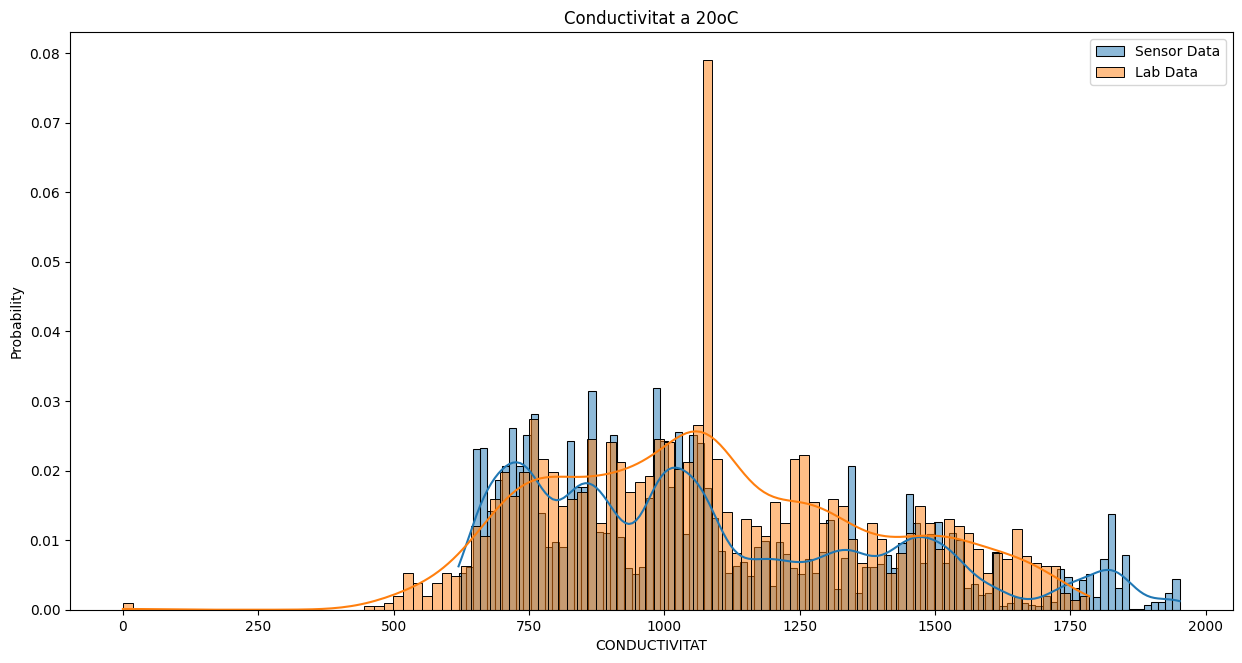

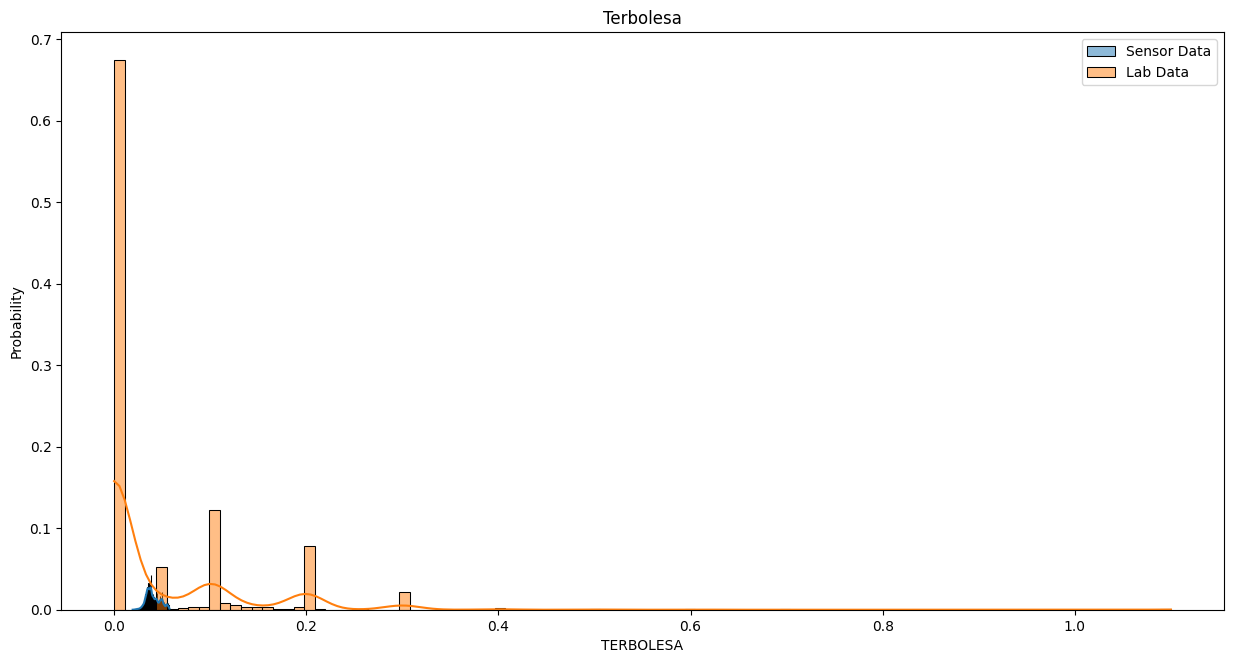

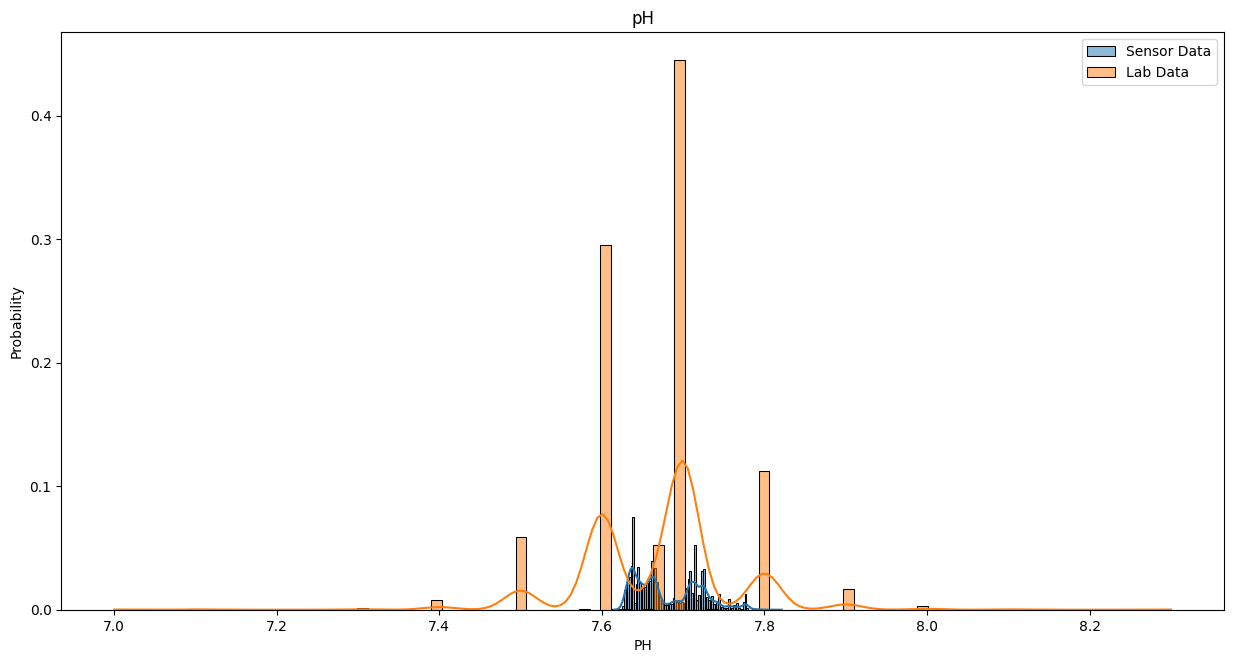

In [215]:
for lab_key, sensor_key in eb1_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb1_features_lab_df[lab_key]
    sensor_df = eb1_sensor_df[sensor_key]

    # remove 0 values from sensor data
    sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        plt.figure(figsize=(15, 7.5))

        # counts, bins, patches = plt.hist(
        #     lab_df,
        #     bins=100,
        #     color="blue",
        #     alpha=0.5,
        #     label="Lab",
        #     density=True,
        # )
        # # # Add counts as annotations
        # # for count, bin in zip(counts, bins):
        # #     plt.text(bin, count, str(int(count)))

        # plt.hist(
        #     sensor_df,
        #     bins=100,
        #     color="red",
        #     alpha=0.5,
        #     label="Sensor",
        #     density=True,
        # )

        sns.histplot(
            data=sensor_df,
            kde=True,
            bins=100,
            alpha=0.5,
            stat="probability",
            label="Sensor Data",
        )

        sns.histplot(
            data=lab_df,
            kde=True,
            bins=100,
            stat="probability",
            label="Lab Data",
        )

        plt.title(lab_key)
        plt.legend()
        plt.show()

        # The y-axis of a histplot with stat="probability" corresponds
        # to the probability that a value belongs to a certain bar.
        # The sum of the bar heights must be 1.

### Boxplots

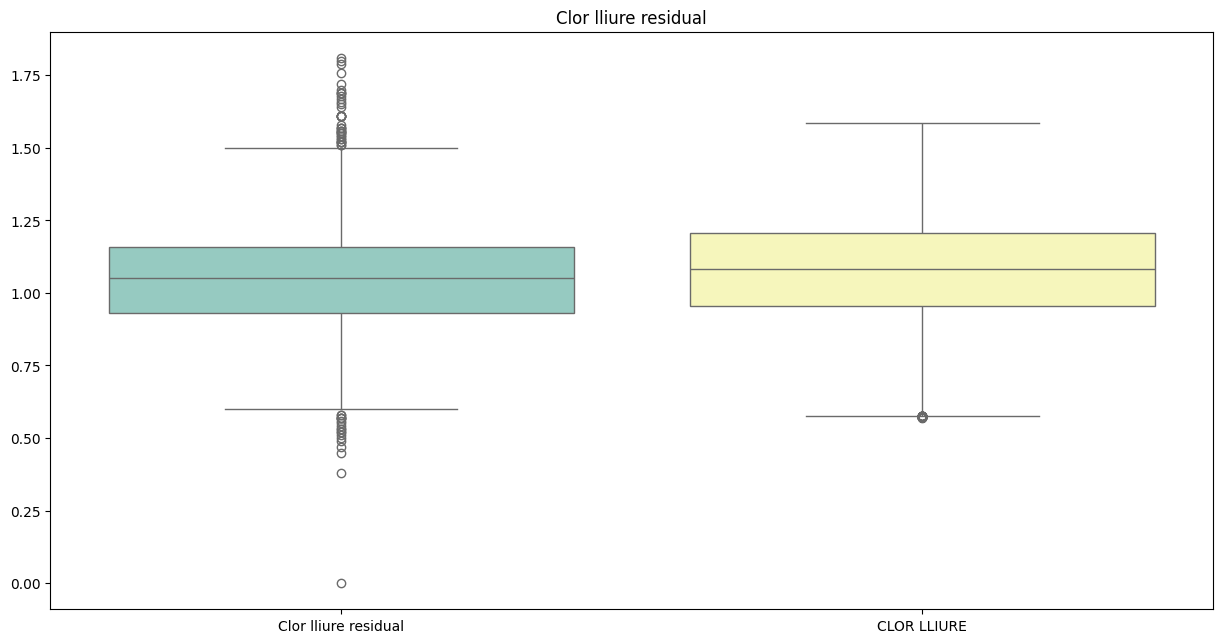

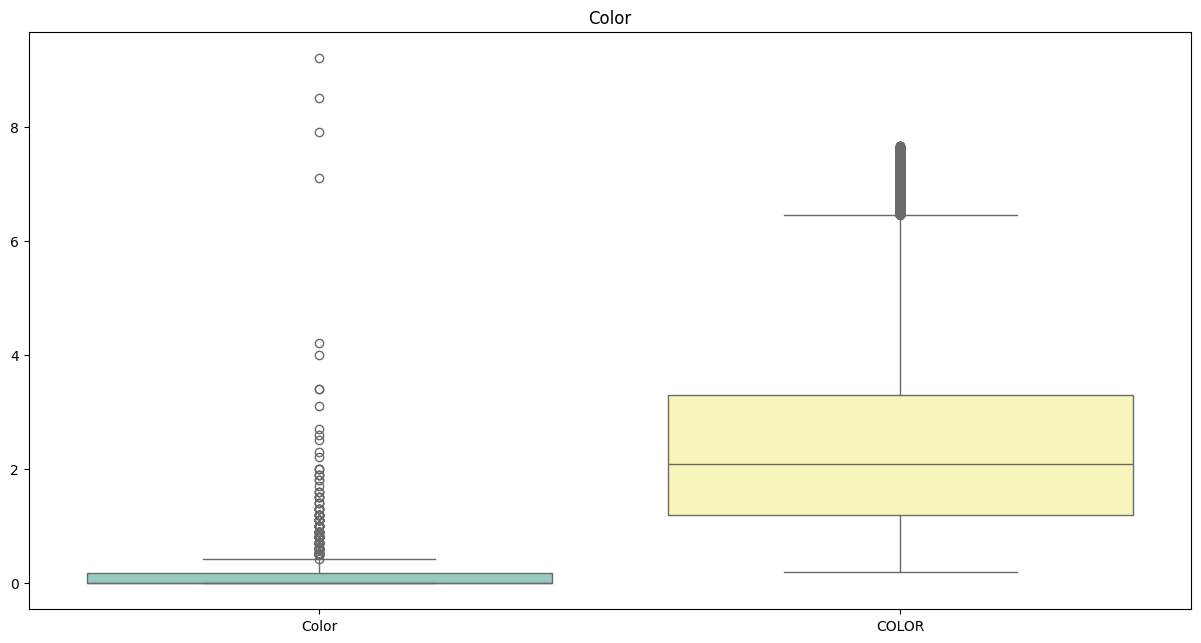

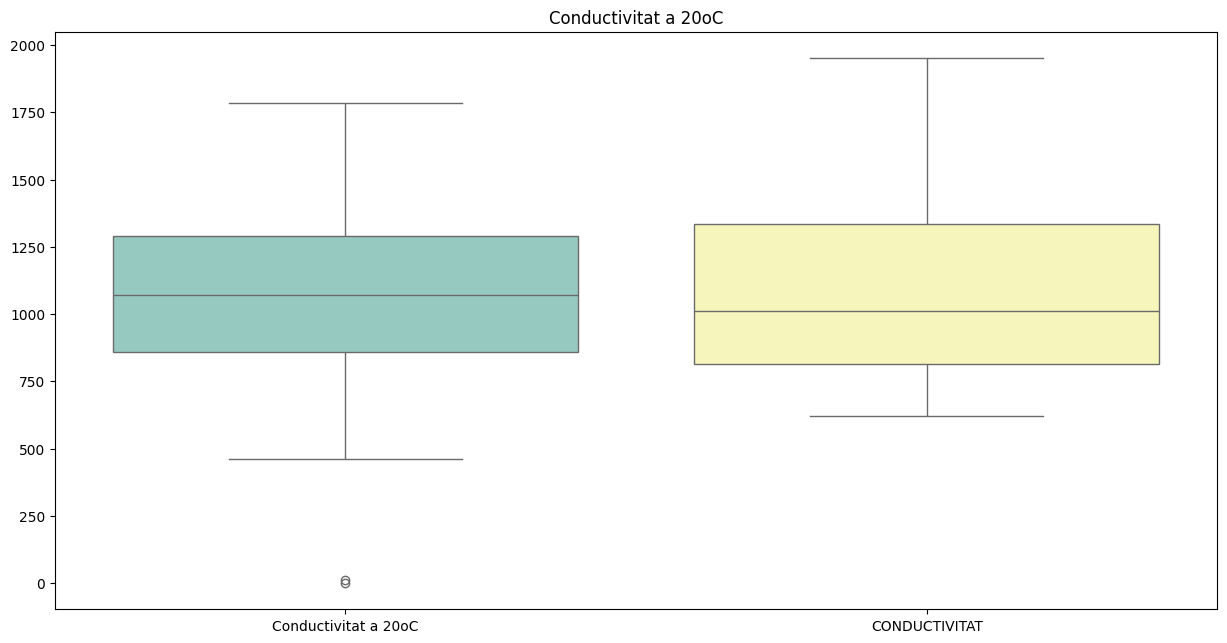

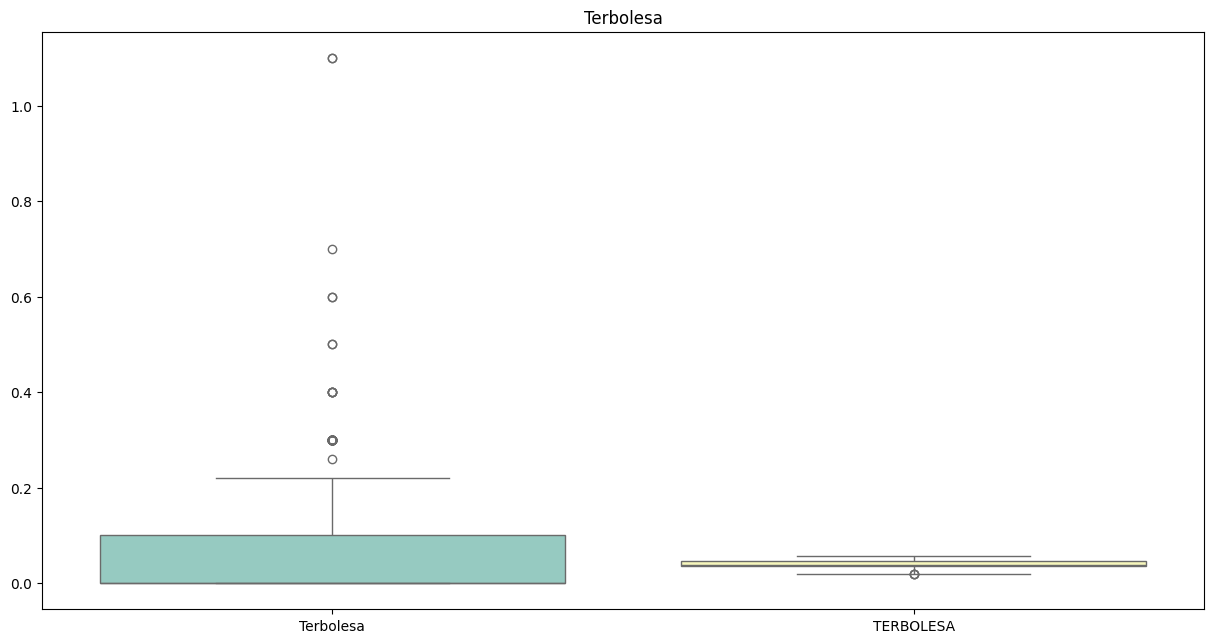

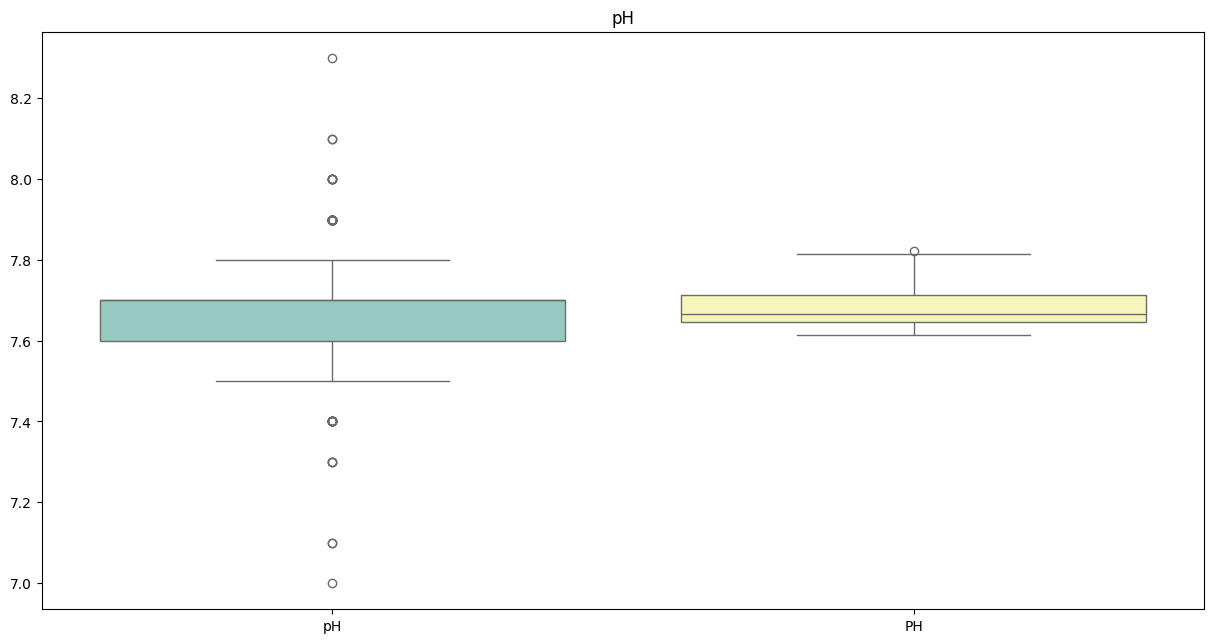

In [216]:
for lab_key, sensor_key in eb1_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb1_features_lab_df[lab_key]
    sensor_df = eb1_sensor_df[sensor_key]

    # remove 0 values from sensor data
    sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        plt.figure(figsize=(15, 7.5))

        sns.boxplot(data=[lab_df, sensor_df], palette="Set3")

        plt.title(lab_key)
        plt.show()

### Time series

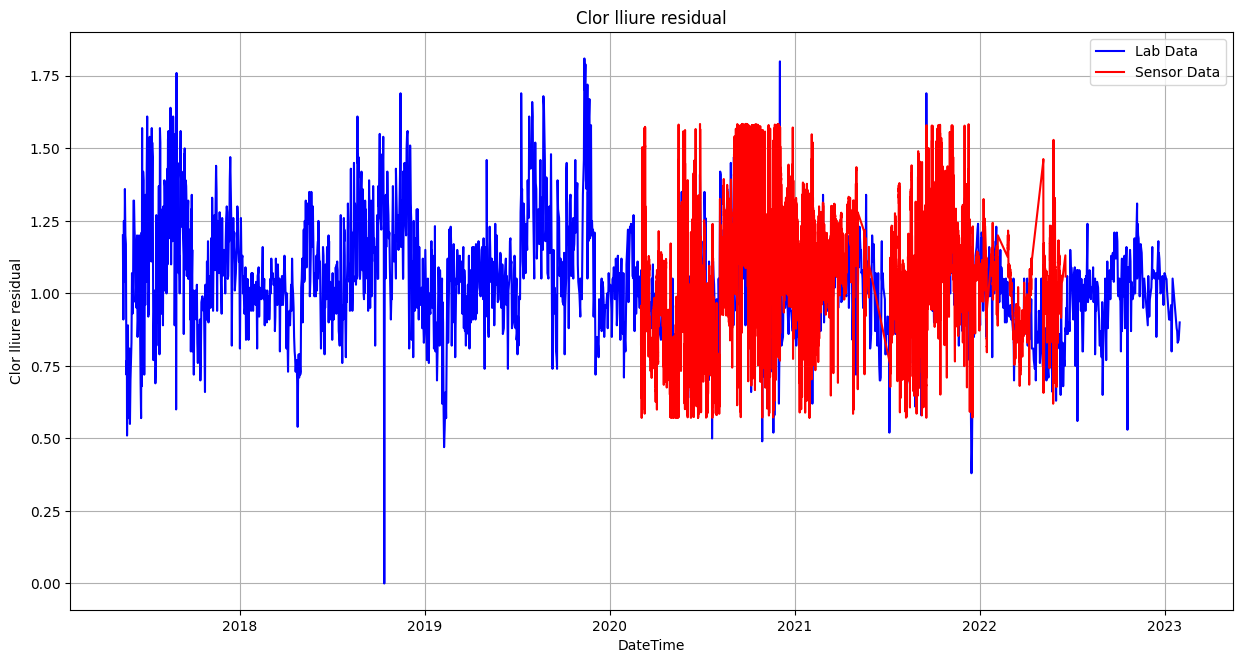

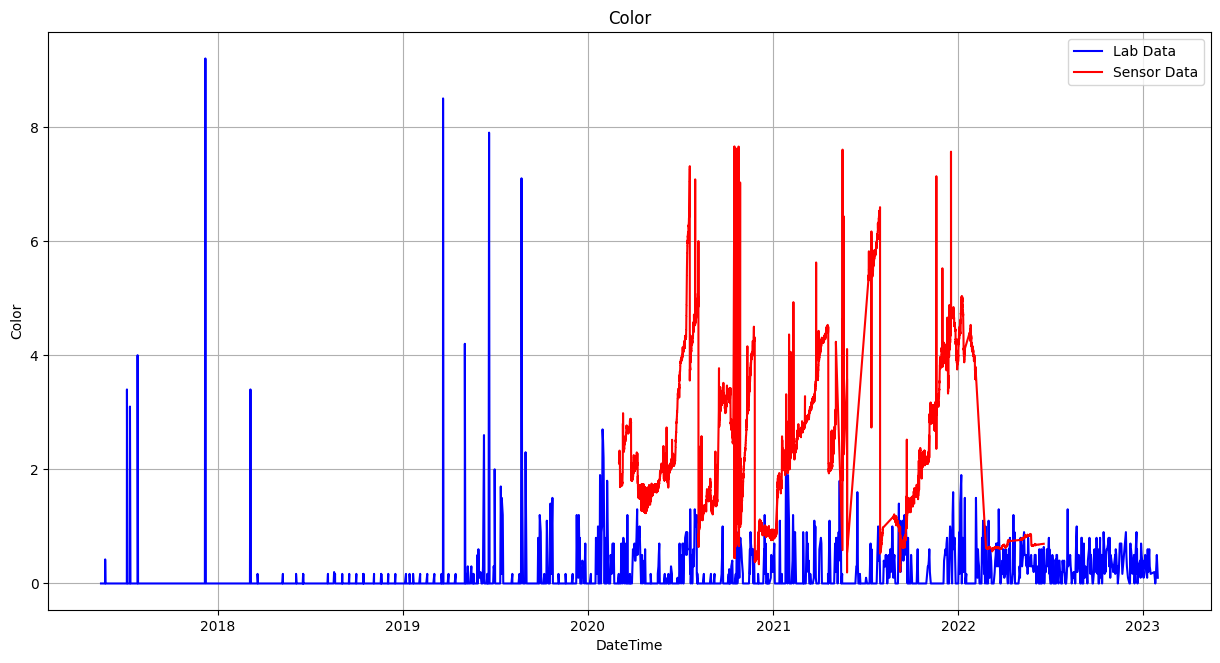

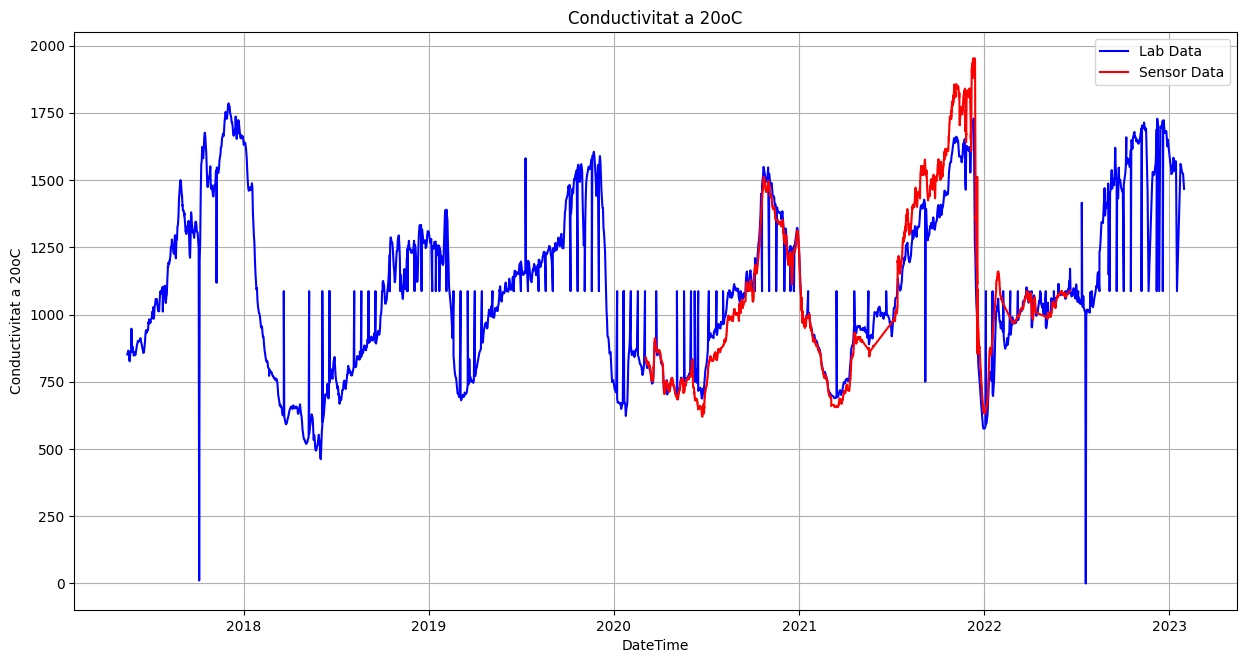

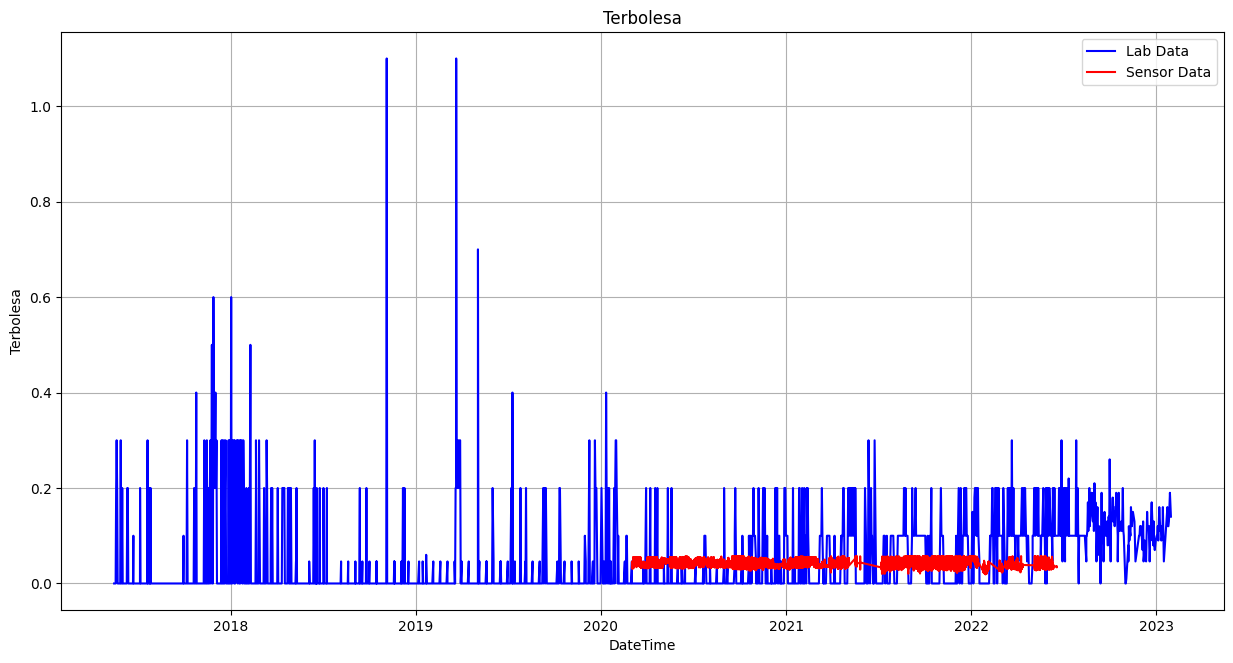

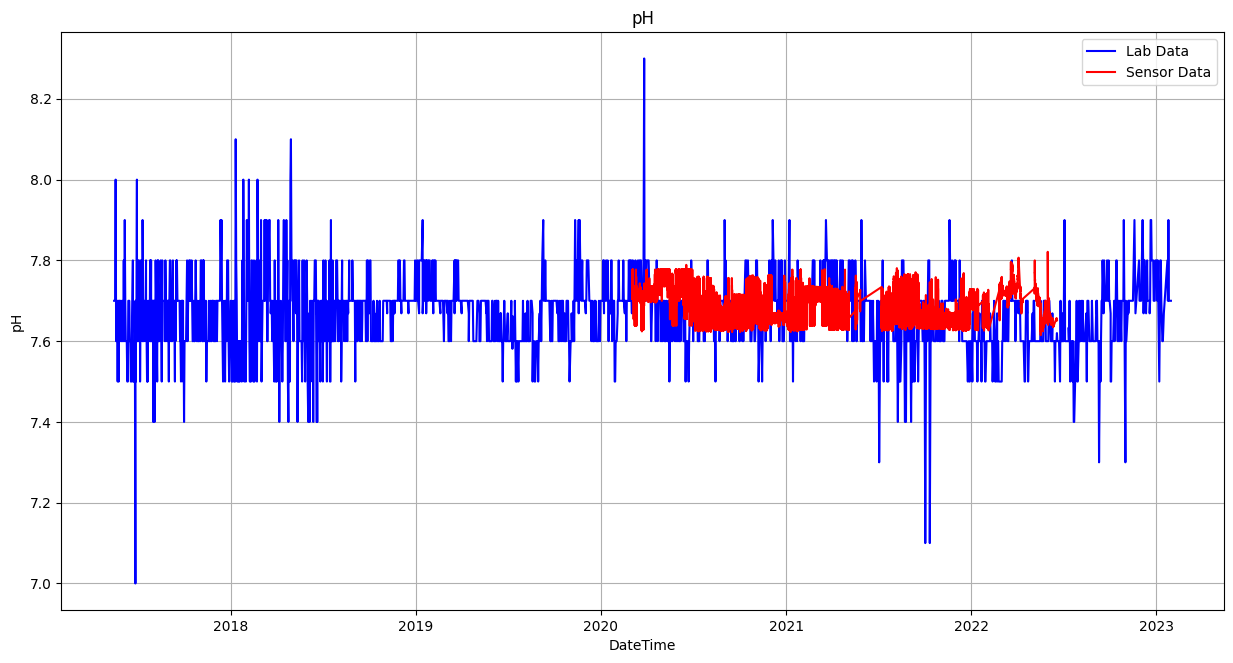

In [235]:
for lab_key, sensor_key in eb1_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb1_features_lab_df[["DateTime", lab_key]]
    sensor_df = eb1_sensor_df[["DateTime", sensor_key]]

    # remove 0 values from sensor data
    sensor_df = sensor_df[sensor_df[sensor_key] != 0]

    if not lab_df.empty and not sensor_df.empty:
        plt.figure(figsize=(15, 7.5))

        sns.lineplot(
            x="DateTime",
            y=lab_key,
            data=lab_df,
            color="blue",
            label="Lab Data",
        )

        sns.lineplot(
            x="DateTime",
            y=sensor_key,
            data=sensor_df,
            color="red",
            label="Sensor Data",
        )

        # sns.scatterplot(
        #     x="DateTime",
        #     y=sensor_key,
        #     data=sensor_df,
        #     color="red",
        #     label="Sensor Data",)

        plt.title(lab_key)
        plt.legend()
        plt.grid(True)
        plt.show()

### Retrieve Common Time Range data + Hypothesis Tests

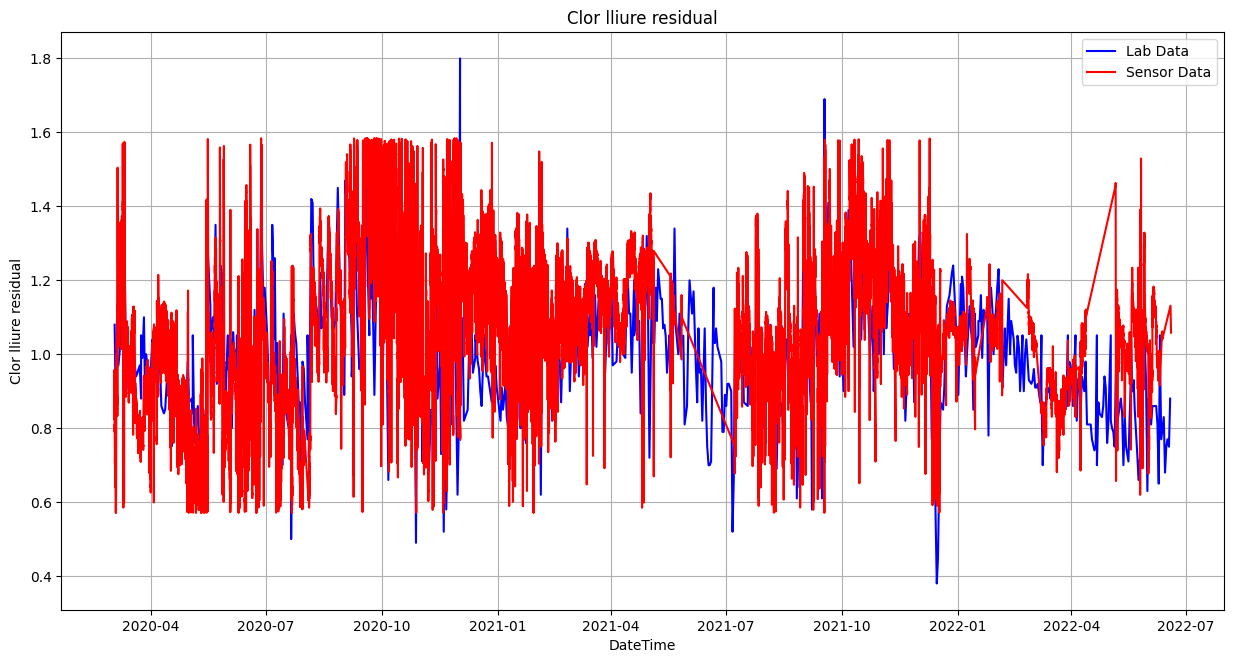

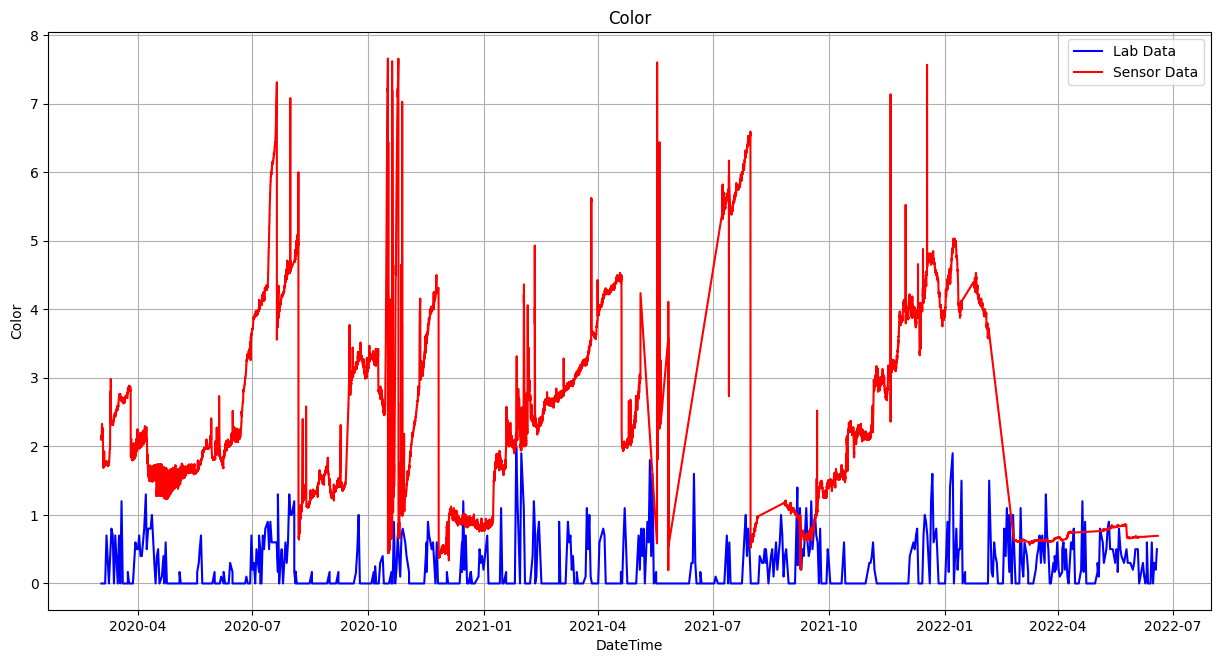

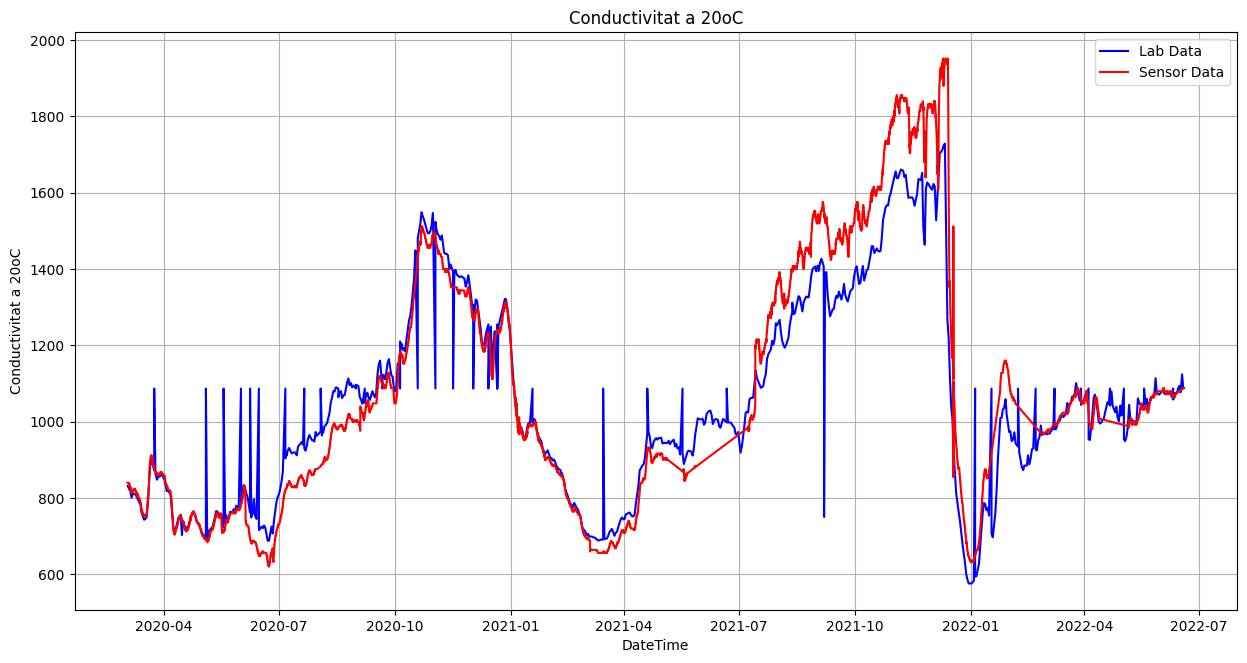

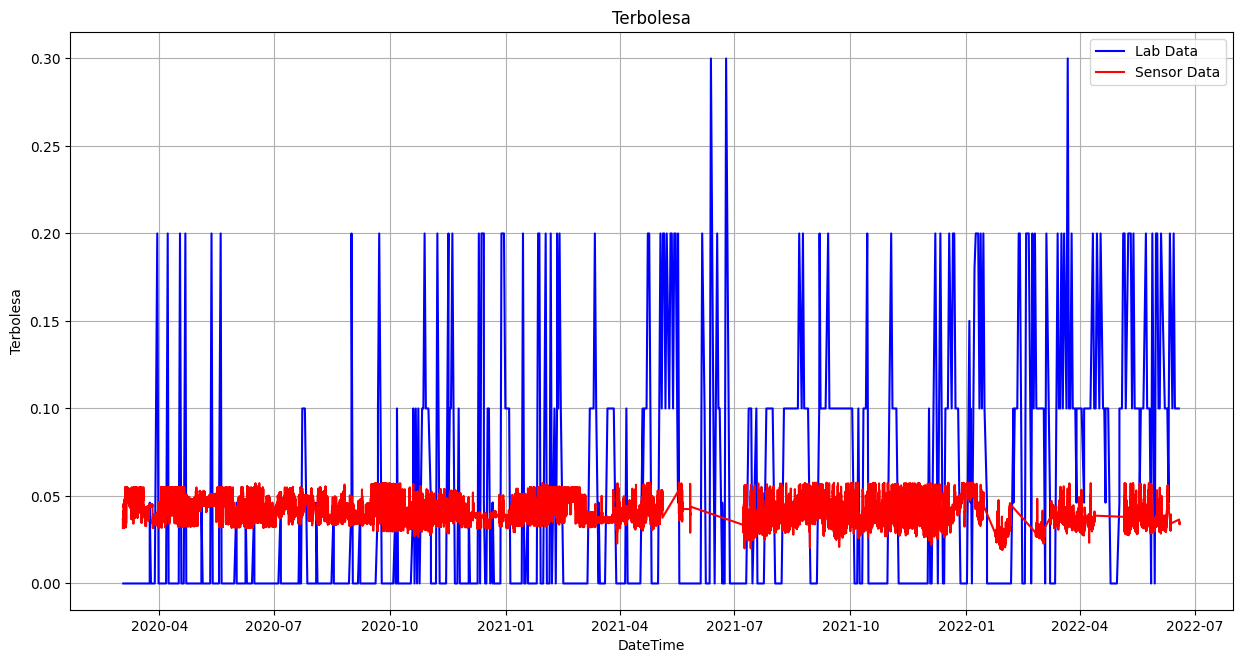

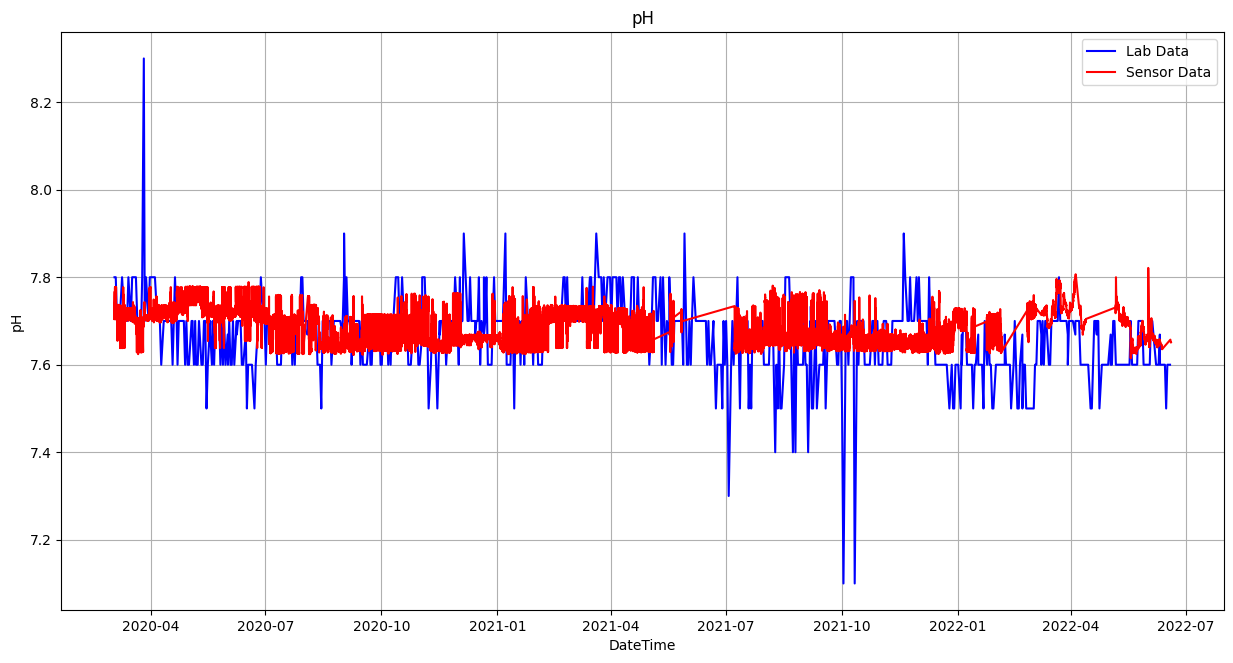

In [218]:
ks_hypothesis_tests = {}
t_hypothesis_tests = {}
u_hypothesis_tests = {}

# get common time range samples for lab and sensor data
for lab_key, sensor_key in eb1_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb1_features_lab_df[["DateTime", lab_key]]
    sensor_df = eb1_sensor_df[["DateTime", sensor_key]]

    # remove 0 values from sensor data
    sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        lab_time_range_df = lab_df[
            (lab_df["DateTime"] >= sensor_df["DateTime"].min())
            & (lab_df["DateTime"] <= sensor_df["DateTime"].max())
        ]

        sensor_time_range_df = sensor_df[
            (sensor_df["DateTime"] >= lab_df["DateTime"].min())
            & (sensor_df["DateTime"] <= lab_df["DateTime"].max())
        ]

        plt.figure(figsize=(15, 7.5))

        sns.lineplot(
            x="DateTime",
            y=lab_key,
            data=lab_time_range_df,
            color="blue",
            label="Lab Data",
        )

        sns.lineplot(
            x="DateTime",
            y=sensor_key,
            data=sensor_time_range_df,
            color="red",
            label="Sensor Data",
        )

        # two sample KS test
        ks_result, ks_p_value = stats.ks_2samp(
            lab_df[lab_key], sensor_df[sensor_key]
        )
        t_result, t_p_value = stats.ttest_ind(
            lab_df[lab_key].dropna(), sensor_df[sensor_key].dropna()
        )
        u_result, u_p_value = stats.mannwhitneyu(
            lab_df[lab_key].dropna(), sensor_df[sensor_key].dropna()
        )

        ks_hypothesis_tests[lab_key] = {
            "ks_test": ks_result,
            "p_value": ks_p_value,
        }

        t_hypothesis_tests[lab_key] = {"t_test": t_result, "p_value": t_p_value}

        u_hypothesis_tests[lab_key] = {"u_test": u_result, "p_value": u_p_value}

        plt.title(lab_key)
        plt.grid(True)
        plt.legend()
        plt.show()

In [219]:
pd.DataFrame(ks_hypothesis_tests).T

,ks_test,p_value
Clor lliure residual,0.140906,1.115584e-35
Color,0.906188,0.000000e+00
Conductivitat a 20oC,0.093708,5.482450e-16
Terbolesa,0.674699,0.000000e+00
pH,0.366961,5.612737e-246


In [220]:
pd.DataFrame(t_hypothesis_tests).T

,t_test,p_value
Clor lliure residual,-6.139658,8.300059e-10
Color,-70.452255,0.000000e+00
Conductivitat a 20oC,0.493332,6.217789e-01
Terbolesa,18.308601,9.298479e-75
pH,-13.085746,4.269510e-39


In [221]:
pd.DataFrame(u_hypothesis_tests).T

,u_test,p_value
Clor lliure residual,93017568.5,1.587416e-17
Color,3989849.0,0.000000e+00
Conductivitat a 20oC,109531819.0,1.270638e-04
Terbolesa,65367888.0,1.805232e-187
pH,91260530.5,7.968575e-23


### Distributions Divergence

In [222]:
kl_divs = {}
js_divs = {}
tv_dists = {}
w_dists = {}

for lab_key, sensor_key in eb1_features_mapping.items():
    # Compute the probability distribution of the feature in each DataFrame
    lab_df = eb1_features_lab_df[lab_key]
    sensor_df = eb1_sensor_df[sensor_key]

    lab_pdist = np.histogram(lab_df.dropna(), bins=100, density=True)[0]
    sensor_pdist = np.histogram(sensor_df.dropna(), bins=100, density=True)[0]

    # Add a small constant to avoid division by zero
    lab_pdist = lab_pdist + np.finfo(np.float64).eps
    sensor_pdist = sensor_pdist + np.finfo(np.float64).eps

    # Compute divergence metrics
    kl_div = stats.entropy(lab_pdist, sensor_pdist)
    js_div = jensenshannon(lab_pdist, sensor_pdist)
    tv_dist = np.sum(np.abs(lab_pdist - sensor_pdist)) / 2
    w_dist = wasserstein_distance(lab_pdist, sensor_pdist)

    kl_divs[lab_key] = kl_div
    js_divs[lab_key] = js_div
    tv_dists[lab_key] = tv_dist
    w_dists[lab_key] = w_dist


kl_divs = pd.Series(kl_divs)
js_divs = pd.Series(js_divs)
tv_dists = pd.Series(tv_dists)
w_dists = pd.Series(w_dists)

In [223]:
kl_divs

Clor lliure residual    0.374730
Color                   8.064984
Conductivitat a 20oC    1.158170
Terbolesa               8.389169
pH                      2.635475
dtype: float64

In [224]:
js_divs

Clor lliure residual    0.321279
Color                   0.732983
Conductivitat a 20oC    0.533996
Terbolesa               0.811348
pH                      0.739308
dtype: float64

In [225]:
tv_dists

Clor lliure residual      27.173374
Color                     10.496498
Conductivitat a 20oC       0.038528
Terbolesa               1337.435014
pH                       245.459863
dtype: float64

In [226]:
w_dists

Clor lliure residual     0.481835
Color                    0.172198
Conductivitat a 20oC     0.000231
Terbolesa               25.186942
pH                       4.076200
dtype: float64

# Lab Data Feature-Target Analysis

In [227]:
trihalometh_columns = [
    "Cloroform",
    "Bromodiclorometà",
    "Dibromoclorometà",
    "Bromoform",
]

acid_columns = [
    "àcid bromocloroacètic",
    "àcid dibromoacètic",
    "àcid dicloroacètic",
    "àcid monobromoacètic",
    "àcid monocloroacètic",
]

other_columns = [
    "Clorat",
    "Clorit",
]

trihalometh_mapping = {
    "Cloroform": "TCM",
    "Bromodiclorometà": "DCBM",
    "Dibromoclorometà": "CDBM",
    "Bromoform": "TBM",
}

## EB1 - THMs

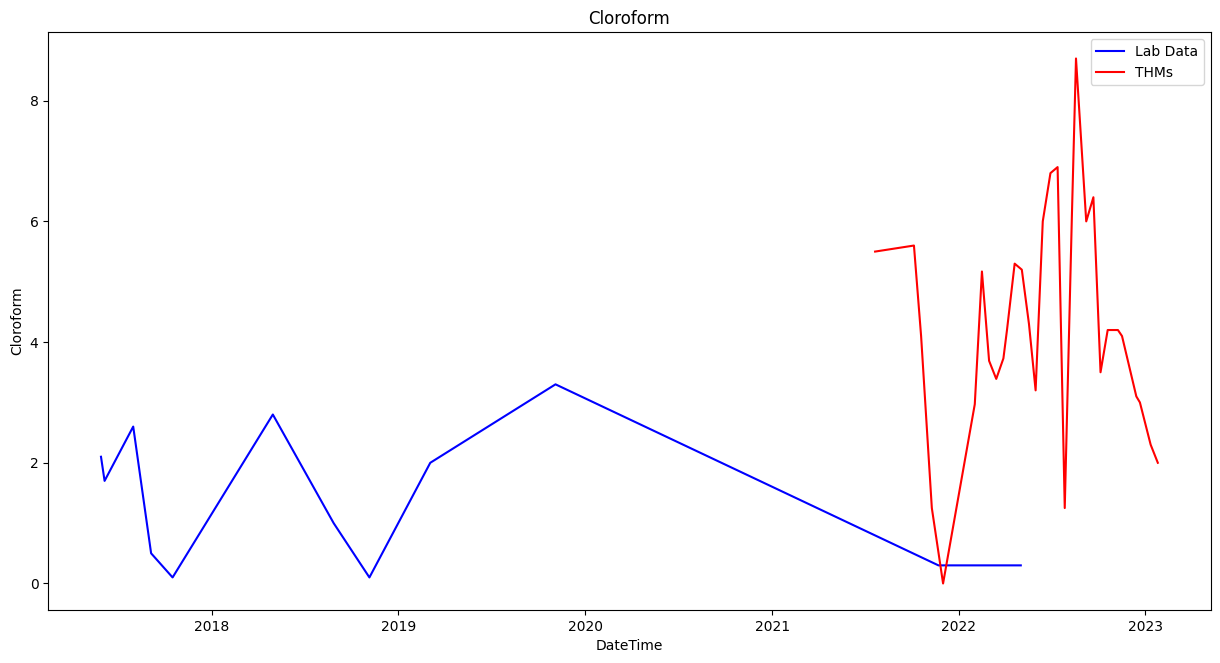

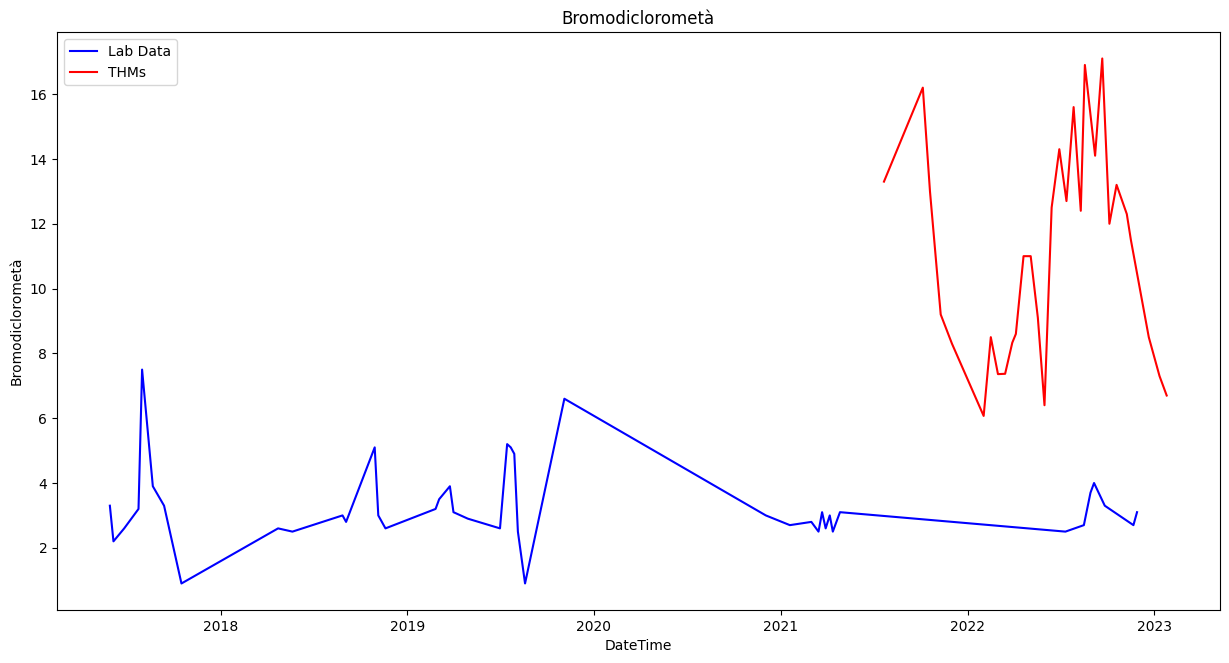

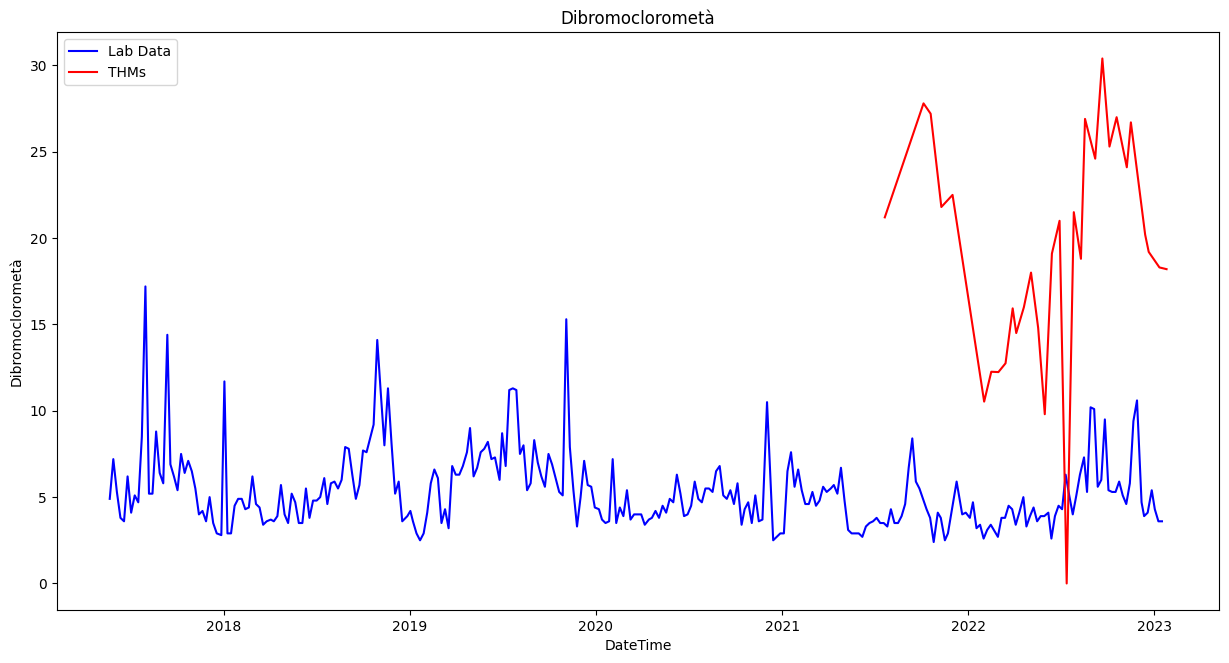

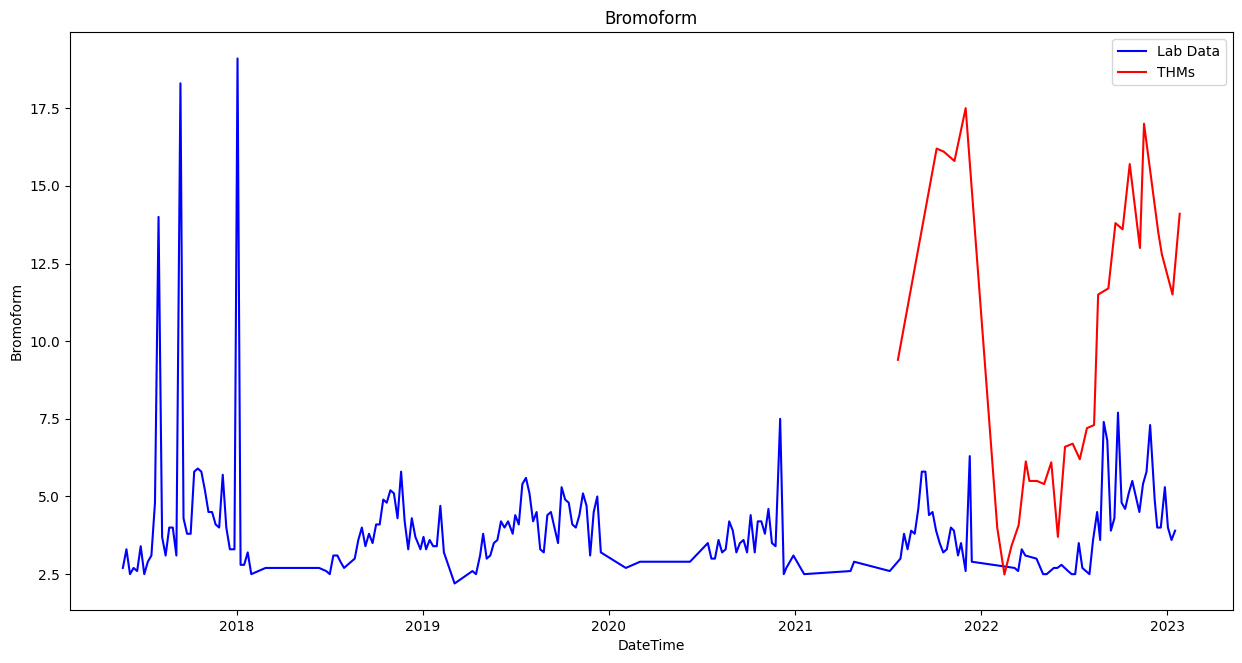

In [228]:
for eb1_key, thm_key in trihalometh_mapping.items():
    plt.figure(figsize=(15, 7.5))

    lab_df = eb1_targets_lab_df[["DateTime", eb1_key]]
    lab_df = lab_df[lab_df != 0]

    thms = thms_df[["DateTime", thm_key]]

    sns.lineplot(
        x="DateTime", y=eb1_key, data=lab_df, color="blue", label="Lab Data"
    )

    sns.lineplot(x="DateTime", y=thm_key, data=thms, color="red", label="THMs")

    plt.title(eb1_key)
    plt.show()

### Join on same day

In [229]:
eb1_targets_lab_df

,DateTime,Bromodiclorometà,Bromoform,Clorat,Clorit,Cloroform,Dibromoclorometà,àcid bromocloroacètic,àcid dibromoacètic,àcid dicloroacètic,àcid monobromoacètic,àcid monocloroacètic
0,2017-05-15 07:40:00,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,2017-05-22 07:15:00,0.0,2.7,0.0,0.0,0.0,4.9,1.3,1.7,0.8,0.0,0.0
2,2017-05-29 07:00:00,3.3,3.3,NaN,NaN,2.1,7.2,NaN,NaN,NaN,NaN,NaN
3,2017-06-05 07:30:00,2.2,2.5,NaN,0.0,1.7,5.3,1.3,1.7,0.7,0.0,0.0
4,2017-06-12 07:40:00,0.0,2.7,NaN,NaN,0.0,3.8,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
298,2022-12-19 06:45:00,0.0,4.0,127.0,0.0,0.0,4.1,0.8,2.2,0.0,0.0,0.0
299,2022-12-27 07:00:00,0.0,5.3,NaN,NaN,0.0,5.4,NaN,NaN,NaN,NaN,NaN
300,2023-01-02 06:55:00,0.0,4.0,136.0,0.0,0.0,4.3,0.9,2.3,0.0,0.0,0.0
301,2023-01-09 08:30:00,0.0,3.6,NaN,NaN,0.0,3.6,NaN,NaN,NaN,NaN,NaN


In [230]:
eb1_features_lab_df

,DateTime,Clor lliure residual,Color,Conductivitat a 20oC,Terbolesa,pH
0,2017-05-15 07:40:00,1.20,0.0,852.0,0.00,7.7
1,2017-05-16 07:45:00,0.91,0.0,857.0,0.00,7.7
2,2017-05-17 07:30:00,1.25,0.0,866.0,0.00,7.7
3,2017-05-18 07:30:00,1.04,0.0,863.0,0.00,8.0
4,2017-05-19 07:30:00,1.36,0.0,830.0,0.20,7.6
...,...,...,...,...,...,...
2070,2023-01-24 08:25:00,0.88,0.1,1552.0,0.12,7.7
2071,2023-01-25 08:30:00,0.87,0.0,1539.0,0.12,7.9
2072,2023-01-26 08:30:00,0.83,0.1,1528.0,0.13,7.7
2073,2023-01-28 08:55:00,0.84,0.5,1524.0,0.19,7.7


In [231]:
eb1_features_lab_df["Date"] = eb1_features_lab_df["DateTime"].dt.date
eb1_targets_lab_df["Date"] = eb1_targets_lab_df["DateTime"].dt.date

eb1_lab_df = pd.merge(
    eb1_features_lab_df, eb1_targets_lab_df, on="Date", how="inner"
)

eb1_features_lab_df.drop(columns=["Date"], inplace=True)
eb1_targets_lab_df.drop(columns=["Date"], inplace=True)

In [232]:
eb1_lab_df

,DateTime_x,Clor lliure residual,Color,Conductivitat a 20oC,Terbolesa,pH,Date,DateTime_y,Bromodiclorometà,Bromoform,Clorat,Clorit,Cloroform,Dibromoclorometà,àcid bromocloroacètic,àcid dibromoacètic,àcid dicloroacètic,àcid monobromoacètic,àcid monocloroacètic
0,2017-05-15 07:40:00,1.20000,0.000000,852.0000,0.000000,7.700000,2017-05-15,2017-05-15 07:40:00,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,2017-05-22 07:15:00,0.72000,0.000000,864.0000,0.000000,7.500000,2017-05-22,2017-05-22 07:15:00,0.0,2.7,0.0,0.0,0.0,4.9,1.3,1.7,0.8,0.0,0.0
2,2017-05-29 07:00:00,0.55000,0.000000,860.0000,0.000000,7.700000,2017-05-29,2017-05-29 07:00:00,3.3,3.3,NaN,NaN,2.1,7.2,NaN,NaN,NaN,NaN,NaN
3,2017-06-05 07:30:00,1.32000,0.000000,902.0000,0.000000,7.900000,2017-06-05,2017-06-05 07:30:00,2.2,2.5,NaN,0.0,1.7,5.3,1.3,1.7,0.7,0.0,0.0
4,2017-06-12 07:40:00,1.20000,0.000000,894.0000,0.000000,7.700000,2017-06-12,2017-06-12 07:40:00,0.0,2.7,NaN,NaN,0.0,3.8,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,2022-12-19 08:00:00,1.05127,0.167914,1086.9093,0.046181,7.668932,2022-12-19,2022-12-19 06:45:00,0.0,4.0,127.0,0.0,0.0,4.1,0.8,2.2,0.0,0.0,0.0
434,2022-12-27 07:00:00,1.06000,0.100000,1655.0000,0.130000,7.700000,2022-12-27,2022-12-27 07:00:00,0.0,5.3,NaN,NaN,0.0,5.4,NaN,NaN,NaN,NaN,NaN
435,2023-01-02 06:55:00,1.06000,0.100000,1580.0000,0.100000,7.800000,2023-01-02,2023-01-02 06:55:00,0.0,4.0,136.0,0.0,0.0,4.3,0.9,2.3,0.0,0.0,0.0
436,2023-01-09 08:30:00,0.91000,0.100000,1583.0000,0.110000,7.800000,2023-01-09,2023-01-09 08:30:00,0.0,3.6,NaN,NaN,0.0,3.6,NaN,NaN,NaN,NaN,NaN


### Join on previous day EB(t-1) -> THMs(t)

In [233]:
eb1_features_lab_df["Date"] = eb1_features_lab_df["DateTime"].dt.date
eb1_targets_lab_df["Date"] = (
    eb1_targets_lab_df["DateTime"] - pd.Timedelta(days=1)
).dt.date

eb1_lab_df = pd.merge(
    eb1_features_lab_df, eb1_targets_lab_df, on="Date", how="inner"
)

eb1_features_lab_df.drop(columns=["Date"], inplace=True)
eb1_targets_lab_df.drop(columns=["Date"], inplace=True)

In [234]:
eb1_lab_df

,DateTime_x,Clor lliure residual,Color,Conductivitat a 20oC,Terbolesa,pH,Date,DateTime_y,Bromodiclorometà,Bromoform,Clorat,Clorit,Cloroform,Dibromoclorometà,àcid bromocloroacètic,àcid dibromoacètic,àcid dicloroacètic,àcid monobromoacètic,àcid monocloroacètic
0,2017-05-21 07:30:00,1.17,0.00,856.0,0.20,7.70,2017-05-21,2017-05-22 07:15:00,0.0,2.7,0.0,0.0,0.0,4.9,1.3,1.7,0.8,0.0,0.0
1,2017-05-28 09:00:00,0.81,0.00,847.0,0.30,7.60,2017-05-28,2017-05-29 07:00:00,3.3,3.3,NaN,NaN,2.1,7.2,NaN,NaN,NaN,NaN,NaN
2,2017-06-04 08:55:00,0.97,0.00,893.0,0.00,7.60,2017-06-04,2017-06-05 07:30:00,2.2,2.5,NaN,0.0,1.7,5.3,1.3,1.7,0.7,0.0,0.0
3,2017-06-11 08:03:00,0.95,0.00,901.0,0.20,7.50,2017-06-11,2017-06-12 07:40:00,0.0,2.7,NaN,NaN,0.0,3.8,NaN,NaN,NaN,NaN,NaN
4,2017-06-18 08:35:00,0.87,0.00,879.0,0.00,7.50,2017-06-18,2017-06-19 08:00:00,0.0,2.6,NaN,NaN,0.0,3.6,1.5,1.5,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,2022-06-19 07:15:00,0.87,0.64,1170.4,0.10,7.62,2022-06-19,2022-06-20 07:00:00,0.0,2.6,447.0,0.0,0.0,3.9,1.3,2.2,0.5,0.0,0.0
102,2022-06-26 11:05:00,0.90,0.50,1098.0,0.20,7.70,2022-06-26,2022-06-27 09:50:00,0.0,2.5,NaN,NaN,0.0,4.5,NaN,NaN,NaN,NaN,NaN
103,2022-09-13 08:32:00,1.03,0.00,1505.0,0.00,7.50,2022-09-13,2022-09-14 07:00:00,NaN,NaN,102.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,2022-12-06 11:00:00,1.08,0.00,1625.0,0.13,7.80,2022-12-06,2022-12-07 06:50:00,0.0,4.9,78.0,0.0,0.0,4.7,0.9,2.4,0.0,0.0,0.0


## Correlation Matrix Heatmap

## Hypothesis Tests Correlations

## Scatter Plots

## Boxplots